# Time Series Regression Analysis (Corporation Favorita)

## `Business Understanding`
**Project Scenario**

You are a data scientist in Corporation Favorita, a large Ecuadorian-based grocery retailer. Corporation Favorita wants to ensure that they always have the right quantity of products in stock. To do this you have decided to build a series of machine learning models to forecast the demand of products in various locations. The marketing and sales team have provided you with some data to aid this endeavor. Your team uses CRISP-DM Framework for Data Science projects

**Problem Statement**

Corporation Favorita aims to optimize its inventory management by accurately forecasting the demand for various products across its stores in Ecuador. The goal is to ensure that each store has the right quantity of products in stock to meet customer demand while minimizing overstocking or stockouts
    
**Objective**

The objective is to build machine learning models that can predict unit sales for different product families at Favorita stores accurately. These models will help optimize inventory levels, improve sales forecasting accuracy, and ultimately enhance customer satisfaction by ensuring product availability.

**Key Stakeholders**

Stakeholders include Corporation Favorita's management, sales and marketing teams, store managers, and data science team.

**Analytical Goals**
- Handle missing values in the datasets by imputation techniques such as mean, median, or mode.
- Address outliers in sales data that may skew the model's predictions by applying robust statistical methods or trimming techniques.
- Normalize or scale numerical features to ensure uniformity and improve model performance.
- Encode categorical variables using techniques such as one-hot encoding or label encoding.
- Build time series regression models such as SARIMA, ARIMA, XGBoost, Linear Regression etc. to capture seasonality and trends in sales data.
- Validate models using cross-validation techniques and assess their performance metrics such as RMSE (Root Mean Squared Error) or MAE (Mean Absolute Error).
- Create insightful visualizations and dashboards for sales analysis and forecasting.

**Success Criteria**
- Achieve a 0.2 RMSE (Root Mean Squared Error) in sales forecasting models.
- Improve inventory management efficiency and reduce stockout instances.

**Constraints and Assumptions**
- Assumption: Historical sales data is representative of future demand patterns.
- Constraint: Limited availability of real-time sales data for model training.

**Data Requirements**
- Utilize data from train.csv, stores.csv, holidays_events.csv, oil.csv, and transaction.csv for analysis.
- Include features such as store_nbr, family, onpromotion, store metadata, oil prices, holidays, and transactional data.

**Business Impact**
- Enhance customer satisfaction through better product availability.
- Optimize inventory management, leading to cost savings and improved operational efficiency.

### `Hypothesis`
Null Hypothesis (Ho): Holidays do not have a significant effect on the sales 

Alternate Hypothesis (Ha): Holidays have a significant effect on the sales

**Analytical Business Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


## `Data Understanding`

#### File Descriptions and Data Field Information

**train.csv**

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

- store_nbr identifies the store at which the products are sold.

- family identifies the type of product sold.

- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

**test.csv**

- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

- The dates in the test data are for the 15 days after the last date in the training data.

**transaction.csv**

- Contains date, store_nbr and transaction made on that specific date.

**sample_submission.csv**

- A sample submission file in the correct format.

**stores.csv**

- Store metadata, including city, state, type, and cluster.

- cluster is a grouping of similar stores.

**oil.csv**

- Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**

Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional Notes**

- Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.


Import Libraries

In [26]:
# Import Data Manupilation Packages
from dotenv import dotenv_values
import pyodbc
import pandas as pd
import polars as pl
import numpy as np

# Import Visualization packages
import seaborn as sns
import seaborn_polars as snl
import matplotlib.pyplot as plt
import plotly.express as px

# Import stats packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.dates as mdates

from itertools import product

# Utility Packages:
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

print("üõ¨ Imported all packages.", "Warnings hidden. üëª")

üõ¨ Imported all packages. Warnings hidden. üëª


#### `First Datasets from Database`
I'm using Python's dotenv with a .env file to safely fetch the first datasets from a SQL database into my notebook. This keeps my database credentials private while allowing easy access to the data for analysis.

In [27]:
# Load environment variables
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [28]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [29]:
# Use the connect method of pyodbc library and pass in the connection string
connection = pyodbc.connect(connection_string)

In [30]:
# sql query to get oil data
query1 = "SELECT * FROM dbo.oil"
oil_df = pl.read_database(query1, connection)

# sql query to get holidays_events
query2 = "SELECT * FROM dbo.holidays_events"
holiday_events_df =  pl.read_database(query2, connection)

#sql query to get stores
query3 = "SELECT * FROM dbo.stores"
stores_df =  pl.read_database(query3, connection)

In [31]:
# # Loading the train Data
# oil_df = pl.read_csv('Data/oil.csv')
# # Loading the train Data
# stores_df = pl.read_csv('Data/stores.csv')
# # Loading the train Data
# holiday_events_df = pl.read_csv('Data/holidays.csv')


In [32]:
oil_df.head()

shape: (5, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ dcoilwtico ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÇ
‚îÇ str        ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ null       ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 93.139999  ‚îÇ
‚îÇ 2013-01-03 ‚îÜ 92.970001  ‚îÇ
‚îÇ 2013-01-04 ‚îÜ 93.120003  ‚îÇ
‚îÇ 2013-01-07 ‚îÜ 93.199997  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [33]:
def to_date(df, date_col):
    # Convert date column to date type
    df = df.with_columns(df[date_col].cast(pl.Date))
    
    # Sort the dataframe using the date column
    df = df.sort(date_col)
        
    return df

In [34]:
# Convert date column to date type
oil_df = to_date(oil_df, 'date')
oil_df

shape: (1_218, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ dcoilwtico ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÇ
‚îÇ date       ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ null       ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 93.139999  ‚îÇ
‚îÇ 2013-01-03 ‚îÜ 92.970001  ‚îÇ
‚îÇ 2013-01-04 ‚îÜ 93.120003  ‚îÇ
‚îÇ 2013-01-07 ‚îÜ 93.199997  ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ 2017-08-25 ‚îÜ 47.650002  ‚îÇ
‚îÇ 2017-08-28 ‚îÜ 46.400002  ‚îÇ
‚îÇ 2017-08-29 ‚îÜ 46.459999  ‚îÇ
‚îÇ 2017-08-30 ‚îÜ 45.959999  ‚îÇ
‚îÇ 2017-08-31 ‚îÜ 47.259998  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [35]:
oil_df.glimpse()

Rows: 1218
Columns: 2
$ date       <date> 2013-01-01, 2013-01-02, 2013-01-03, 2013-01-04, 2013-01-07, 2013-01-08, 2013-01-09, 2013-01-10, 2013-01-11, 2013-01-14
$ dcoilwtico  <f64> None, 93.13999938964844, 92.97000122070312, 93.12000274658203, 93.19999694824219, 93.20999908447266, 93.08000183105469, 93.80999755859375, 93.5999984741211, 94.2699966430664



In [36]:
oil_df.null_count()

shape: (1, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date ‚îÜ dcoilwtico ‚îÇ
‚îÇ ---  ‚îÜ ---        ‚îÇ
‚îÇ u32  ‚îÜ u32        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 43         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [37]:
holiday_events_df.head()

shape: (5, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ type    ‚îÜ locale   ‚îÜ locale_name ‚îÜ description                   ‚îÜ transferred ‚îÇ
‚îÇ ---        ‚îÜ ---     ‚îÜ ---      ‚îÜ ---         ‚îÜ ---                           ‚îÜ ---         ‚îÇ
‚îÇ str        ‚îÜ str     ‚îÜ str      ‚îÜ str         ‚îÜ str                           ‚îÜ bool        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2012-03-02 ‚îÜ Holiday ‚îÜ Local    ‚îÜ Manta       ‚îÜ Fundacion de Manta            ‚îÜ false       ‚îÇ
‚îÇ 2012-04-01 ‚îÜ Holiday ‚îÜ Regional ‚îÜ Cotopaxi    ‚îÜ Provincializacion de Cotopaxi ‚îÜ false       ‚îÇ
‚îÇ 2012-04-12 ‚îÜ Holiday ‚îÜ Local    ‚îÜ Cuenca      ‚îÜ Fundacion de Cuenca           ‚îÜ false       ‚îÇ
‚îÇ 2012-04-14 ‚îÜ Holiday ‚îÜ Local    ‚îÜ Libertad    ‚îÜ Cantonizacion de Libertad     ‚îÜ false       ‚îÇ
‚îÇ 2012-04-21 ‚îÜ Holiday ‚îÜ Local    ‚îÜ Riobamba    ‚îÜ Cantonizacion de Riobamba     ‚îÜ false       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [38]:
# Convert date column to datetime type
holiday_events_df = to_date(holiday_events_df, 'date')
holiday_events_df

shape: (350, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ type       ‚îÜ locale   ‚îÜ locale_name ‚îÜ description                   ‚îÜ transferred ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---      ‚îÜ ---         ‚îÜ ---                           ‚îÜ ---         ‚îÇ
‚îÇ date       ‚îÜ str        ‚îÜ str      ‚îÜ str         ‚îÜ str                           ‚îÜ bool        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2012-03-02 ‚îÜ Holiday    ‚îÜ Local    ‚îÜ Manta       ‚îÜ Fundacion de Manta            ‚îÜ false       ‚îÇ
‚îÇ 2012-04-01 ‚îÜ Holiday    ‚îÜ Regional ‚îÜ Cotopaxi    ‚îÜ Provincializacion de Cotopaxi ‚îÜ false       ‚îÇ
‚îÇ 2012-04-12 ‚îÜ Holiday    ‚îÜ Local    ‚îÜ Cuenca      ‚îÜ Fundacion de Cuenca           ‚îÜ false       ‚îÇ
‚îÇ 2012-04-14 ‚îÜ Holiday    ‚îÜ Local    ‚îÜ Libertad    ‚îÜ Cantonizacion de Libertad     ‚îÜ false       ‚îÇ
‚îÇ 2012-04-21 ‚îÜ Holiday    ‚îÜ Local    ‚îÜ Riobamba    ‚îÜ Cantonizacion de Riobamba     ‚îÜ false       ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶                             ‚îÜ ‚Ä¶           ‚îÇ
‚îÇ 2017-12-22 ‚îÜ Additional ‚îÜ National ‚îÜ Ecuador     ‚îÜ Navidad-3                     ‚îÜ false       ‚îÇ
‚îÇ 2017-12-23 ‚îÜ Additional ‚îÜ National ‚îÜ Ecuador     ‚îÜ Navidad-2                     ‚îÜ false       ‚îÇ
‚îÇ 2017-12-24 ‚îÜ Additional ‚îÜ National ‚îÜ Ecuador     ‚îÜ Navidad-1                     ‚îÜ false       ‚îÇ
‚îÇ 2017-12-25 ‚îÜ Holiday    ‚îÜ National ‚îÜ Ecuador     ‚îÜ Navidad                       ‚îÜ false       ‚îÇ
‚îÇ 2017-12-26 ‚îÜ Additional ‚îÜ National ‚îÜ Ecuador     ‚îÜ Navidad+1                     ‚îÜ false       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [39]:
holiday_events_df.glimpse()

Rows: 350
Columns: 6
$ date        <date> 2012-03-02, 2012-04-01, 2012-04-12, 2012-04-14, 2012-04-21, 2012-05-12, 2012-06-23, 2012-06-25, 2012-06-25, 2012-06-25
$ type         <str> 'Holiday', 'Holiday', 'Holiday', 'Holiday', 'Holiday', 'Holiday', 'Holiday', 'Holiday', 'Holiday', 'Holiday'
$ locale       <str> 'Local', 'Regional', 'Local', 'Local', 'Local', 'Local', 'Local', 'Regional', 'Local', 'Local'
$ locale_name  <str> 'Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda', 'Imbabura', 'Latacunga', 'Machala'
$ description  <str> 'Fundacion de Manta', 'Provincializacion de Cotopaxi', 'Fundacion de Cuenca', 'Cantonizacion de Libertad', 'Cantonizacion de Riobamba', 'Cantonizacion del Puyo', 'Cantonizacion de Guaranda', 'Provincializacion de Imbabura', 'Cantonizacion de Latacunga', 'Fundacion de Machala'
$ transferred <bool> False, False, False, False, False, False, False, False, False, False



In [40]:
holiday_events_df.null_count()

shape: (1, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date ‚îÜ type ‚îÜ locale ‚îÜ locale_name ‚îÜ description ‚îÜ transferred ‚îÇ
‚îÇ ---  ‚îÜ ---  ‚îÜ ---    ‚îÜ ---         ‚îÜ ---         ‚îÜ ---         ‚îÇ
‚îÇ u32  ‚îÜ u32  ‚îÜ u32    ‚îÜ u32         ‚îÜ u32         ‚îÜ u32         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 0    ‚îÜ 0      ‚îÜ 0           ‚îÜ 0           ‚îÜ 0           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [41]:
stores_df.head()

shape: (5, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ store_nbr ‚îÜ city          ‚îÜ state                          ‚îÜ type ‚îÜ cluster ‚îÇ
‚îÇ ---       ‚îÜ ---           ‚îÜ ---                            ‚îÜ ---  ‚îÜ ---     ‚îÇ
‚îÇ i64       ‚îÜ str           ‚îÜ str                            ‚îÜ str  ‚îÜ i64     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1         ‚îÜ Quito         ‚îÜ Pichincha                      ‚îÜ D    ‚îÜ 13      ‚îÇ
‚îÇ 2         ‚îÜ Quito         ‚îÜ Pichincha                      ‚îÜ D    ‚îÜ 13      ‚îÇ
‚îÇ 3         ‚îÜ Quito         ‚îÜ Pichincha                      ‚îÜ D    ‚îÜ 8       ‚îÇ
‚îÇ 4         ‚îÜ Quito         ‚îÜ Pichincha                      ‚îÜ D    ‚îÜ 9       ‚îÇ
‚îÇ 5         ‚îÜ Santo Domingo ‚îÜ Santo Domingo de los Tsachilas ‚îÜ D    ‚îÜ 4       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [42]:
stores_df.glimpse()

Rows: 54
Columns: 5
$ store_nbr <i64> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
$ city      <str> 'Quito', 'Quito', 'Quito', 'Quito', 'Santo Domingo', 'Quito', 'Quito', 'Quito', 'Quito', 'Quito'
$ state     <str> 'Pichincha', 'Pichincha', 'Pichincha', 'Pichincha', 'Santo Domingo de los Tsachilas', 'Pichincha', 'Pichincha', 'Pichincha', 'Pichincha', 'Pichincha'
$ type      <str> 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'B', 'C'
$ cluster   <i64> 13, 13, 8, 9, 4, 13, 8, 8, 6, 15



In [43]:
stores_df.null_count()

shape: (1, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ store_nbr ‚îÜ city ‚îÜ state ‚îÜ type ‚îÜ cluster ‚îÇ
‚îÇ ---       ‚îÜ ---  ‚îÜ ---   ‚îÜ ---  ‚îÜ ---     ‚îÇ
‚îÇ u32       ‚îÜ u32  ‚îÜ u32   ‚îÜ u32  ‚îÜ u32     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0         ‚îÜ 0    ‚îÜ 0     ‚îÜ 0    ‚îÜ 0       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

`Second Datasets from Github`

I obtained the second datasets from a GitHub repository, and I'll use Pandas to import the CSV file into my notebook for analysis.

In [44]:
# Loading the train Data
train_df = pl.read_csv('Data/train.csv')

# Loading the transaction data
transactions_df = pl.read_csv('Data/transactions.csv')

In [45]:
transactions_df.head(3)

shape: (3, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ store_nbr ‚îÜ transactions ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---          ‚îÇ
‚îÇ str        ‚îÜ i64       ‚îÜ i64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ 25        ‚îÜ 770          ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 1         ‚îÜ 2111         ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 2         ‚îÜ 2358         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [46]:
# Convert date column to date type
transactions_df = to_date(transactions_df, 'date')
transactions_df

shape: (83_488, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ store_nbr ‚îÜ transactions ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---          ‚îÇ
‚îÇ date       ‚îÜ i64       ‚îÜ i64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ 25        ‚îÜ 770          ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 1         ‚îÜ 2111         ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 2         ‚îÜ 2358         ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 3         ‚îÜ 3487         ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 4         ‚îÜ 1922         ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶            ‚îÇ
‚îÇ 2017-08-15 ‚îÜ 50        ‚îÜ 2804         ‚îÇ
‚îÇ 2017-08-15 ‚îÜ 51        ‚îÜ 1573         ‚îÇ
‚îÇ 2017-08-15 ‚îÜ 52        ‚îÜ 2255         ‚îÇ
‚îÇ 2017-08-15 ‚îÜ 53        ‚îÜ 932          ‚îÇ
‚îÇ 2017-08-15 ‚îÜ 54        ‚îÜ 802          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [47]:
transactions_df.glimpse()

Rows: 83488
Columns: 3
$ date         <date> 2013-01-01, 2013-01-02, 2013-01-02, 2013-01-02, 2013-01-02, 2013-01-02, 2013-01-02, 2013-01-02, 2013-01-02, 2013-01-02
$ store_nbr     <i64> 25, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ transactions  <i64> 770, 2111, 2358, 3487, 1922, 1903, 2143, 1874, 3250, 2940



In [48]:
train_df.null_count()

shape: (1, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ id  ‚îÜ date ‚îÜ store_nbr ‚îÜ family ‚îÜ sales ‚îÜ onpromotion ‚îÇ
‚îÇ --- ‚îÜ ---  ‚îÜ ---       ‚îÜ ---    ‚îÜ ---   ‚îÜ ---         ‚îÇ
‚îÇ u32 ‚îÜ u32  ‚îÜ u32       ‚îÜ u32    ‚îÜ u32   ‚îÜ u32         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0   ‚îÜ 0    ‚îÜ 0         ‚îÜ 0      ‚îÜ 0     ‚îÜ 0           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [49]:
train_df.head(3)

shape: (3, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ id  ‚îÜ date       ‚îÜ store_nbr ‚îÜ family     ‚îÜ sales ‚îÜ onpromotion ‚îÇ
‚îÇ --- ‚îÜ ---        ‚îÜ ---       ‚îÜ ---        ‚îÜ ---   ‚îÜ ---         ‚îÇ
‚îÇ i64 ‚îÜ str        ‚îÜ i64       ‚îÜ str        ‚îÜ f64   ‚îÜ i64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ AUTOMOTIVE ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îÇ 1   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ BABY CARE  ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îÇ 2   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ BEAUTY     ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [50]:
train_df.glimpse()

Rows: 3000888
Columns: 6
$ id          <i64> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ date        <str> '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01'
$ store_nbr   <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ family      <str> 'AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI'
$ sales       <f64> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ onpromotion <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0



In [51]:
# Convert date column in train df to date type
train_df = to_date(train_df, 'date')

In [52]:
# Preview of the train data frame
train_df.head()

shape: (5, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ id  ‚îÜ date       ‚îÜ store_nbr ‚îÜ family     ‚îÜ sales ‚îÜ onpromotion ‚îÇ
‚îÇ --- ‚îÜ ---        ‚îÜ ---       ‚îÜ ---        ‚îÜ ---   ‚îÜ ---         ‚îÇ
‚îÇ i64 ‚îÜ date       ‚îÜ i64       ‚îÜ str        ‚îÜ f64   ‚îÜ i64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ AUTOMOTIVE ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îÇ 1   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ BABY CARE  ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îÇ 2   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ BEAUTY     ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îÇ 3   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ BEVERAGES  ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îÇ 4   ‚îÜ 2013-01-01 ‚îÜ 1         ‚îÜ BOOKS      ‚îÜ 0.0   ‚îÜ 0           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [53]:
train_df.glimpse()

Rows: 3000888
Columns: 6
$ id           <i64> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ date        <date> 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01
$ store_nbr    <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ family       <str> 'AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI'
$ sales        <f64> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ onpromotion  <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0



In [54]:
train_df.null_count()

shape: (1, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ id  ‚îÜ date ‚îÜ store_nbr ‚îÜ family ‚îÜ sales ‚îÜ onpromotion ‚îÇ
‚îÇ --- ‚îÜ ---  ‚îÜ ---       ‚îÜ ---    ‚îÜ ---   ‚îÜ ---         ‚îÇ
‚îÇ u32 ‚îÜ u32  ‚îÜ u32       ‚îÜ u32    ‚îÜ u32   ‚îÜ u32         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0   ‚îÜ 0    ‚îÜ 0         ‚îÜ 0      ‚îÜ 0     ‚îÜ 0           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### **Exploratory Data Analysis (EDA)**

In [55]:
# Checking the descriptive statistics of the train data set
train_df.describe()

shape: (9, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ id            ‚îÜ date       ‚îÜ store_nbr  ‚îÜ family     ‚îÜ sales       ‚îÜ onpromotion ‚îÇ
‚îÇ ---        ‚îÜ ---           ‚îÜ ---        ‚îÜ ---        ‚îÜ ---        ‚îÜ ---         ‚îÜ ---         ‚îÇ
‚îÇ str        ‚îÜ f64           ‚îÜ str        ‚îÜ f64        ‚îÜ str        ‚îÜ f64         ‚îÜ f64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 3.000888e6    ‚îÜ 3000888    ‚îÜ 3.000888e6 ‚îÜ 3000888    ‚îÜ 3.000888e6  ‚îÜ 3.000888e6  ‚îÇ
‚îÇ null_count ‚îÜ 0.0           ‚îÜ 0          ‚îÜ 0.0        ‚îÜ 0          ‚îÜ 0.0         ‚îÜ 0.0         ‚îÇ
‚îÇ mean       ‚îÜ 1500443.5     ‚îÜ 2015-04-24 ‚îÜ 27.5       ‚îÜ null       ‚îÜ 357.775749  ‚îÜ 2.60277     ‚îÇ
‚îÇ std        ‚îÜ 866281.891642 ‚îÜ null       ‚îÜ 15.585787  ‚îÜ null       ‚îÜ 1101.997721 ‚îÜ 12.218882   ‚îÇ
‚îÇ min        ‚îÜ 0.0           ‚îÜ 2013-01-01 ‚îÜ 1.0        ‚îÜ AUTOMOTIVE ‚îÜ 0.0         ‚îÜ 0.0         ‚îÇ
‚îÇ 25%        ‚îÜ 750222.0      ‚îÜ 2014-02-27 ‚îÜ 14.0       ‚îÜ null       ‚îÜ 0.0         ‚îÜ 0.0         ‚îÇ
‚îÇ 50%        ‚îÜ 1.500444e6    ‚îÜ 2015-04-25 ‚îÜ 28.0       ‚îÜ null       ‚îÜ 11.0        ‚îÜ 0.0         ‚îÇ
‚îÇ 75%        ‚îÜ 2.250665e6    ‚îÜ 2016-06-19 ‚îÜ 41.0       ‚îÜ null       ‚îÜ 195.847     ‚îÜ 0.0         ‚îÇ
‚îÇ max        ‚îÜ 3.000887e6    ‚îÜ 2017-08-15 ‚îÜ 54.0       ‚îÜ SEAFOOD    ‚îÜ 124717.0    ‚îÜ 741.0       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [56]:
# Checking  for unique values in all the columns
cols = train_df.columns

results = []

for col in cols:
    
    unique_values = train_df[col].unique()
    num_unique_values = train_df[col].n_unique()
    results.append([col, unique_values, num_unique_values])

results_df = pl.DataFrame(results, schema=['Column', 'Unique_Values', 'Num_Unique_Values'])
results_df

shape: (6, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Column      ‚îÜ Unique_Values                     ‚îÜ Num_Unique_Values ‚îÇ
‚îÇ ---         ‚îÜ ---                               ‚îÜ ---               ‚îÇ
‚îÇ str         ‚îÜ list[str]                         ‚îÜ i64               ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ id          ‚îÜ ["0", "1", ‚Ä¶ "3000887"]           ‚îÜ 3000888           ‚îÇ
‚îÇ date        ‚îÜ ["2013-01-01", "2013-01-02", ‚Ä¶ "‚Ä¶ ‚îÜ 1684              ‚îÇ
‚îÇ store_nbr   ‚îÜ ["1", "2", ‚Ä¶ "54"]                ‚îÜ 54                ‚îÇ
‚îÇ family      ‚îÜ ["HARDWARE", "HOME APPLIANCES", ‚Ä¶ ‚îÜ 33                ‚îÇ
‚îÇ sales       ‚îÜ ["0.0", "0.122", ‚Ä¶ "124717.0"]    ‚îÜ 379610            ‚îÇ
‚îÇ onpromotion ‚îÜ ["0", "1", ‚Ä¶ "741"]               ‚îÜ 362               ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Checking for Data Completness and Missing dates in our Date column

In [57]:
def start_end_date(df):
    # Start of the data using the date
    start_date = df['date'].min()
 
    # End of the data using the date
    end_date = df['date'].max()
 
    # Print the start and end date of the data
    print(f'Start date is {start_date}')
    print(f'End date is {end_date}')
   
    return start_date, end_date

In [58]:
start_date, end_date = start_end_date(train_df)

Start date is 2013-01-01
End date is 2017-08-15


In [59]:
def missing_dates(df):
    # Getting the date range for the train data set
    date_range = pl.date_range(start = start_date, end = end_date, interval = '1d', eager = True)
    
    # Getting the existing dates
    existing_dates = df['date']

    # Getting the missing dates using the date range and the existing dates
    missing_dates = date_range.filter(~date_range.is_in(existing_dates))
    
    return missing_dates

- Check missing dates

In [60]:
# Check missing dates
all_missing_dates = missing_dates(train_df)
all_missing_dates

shape: (4,)
Series: 'literal' [date]
[
	2013-12-25
	2014-12-25
	2015-12-25
	2016-12-25
]

In [61]:
# Dropping the Id column since it will not be relevant for our visualizations
train_df = train_df.drop(columns = ['id'])

In [62]:
train_df.shape

(3000888, 5)

In [63]:
# Define the columns to fill
columns = [column for column in train_df.columns if column != 'date']
columns

['store_nbr', 'family', 'sales', 'onpromotion']

In [64]:
no_enteries_per_day = (train_df.select(pl.col('date').filter(date=pl.col('date').min()))).shape[0]
no_enteries_per_day

1782

In [65]:
no_enteries_per_day * len(all_missing_dates)

7128

- Create missing dataframe using all missing dates, unique store_nbr and unique family category

In [66]:
# Create df with unique values for store_nbr
store_nbr_unique = train_df['store_nbr'].unique()

# Create df with unique values for family category
family_unique = train_df['family'].unique()

# Create dataframe with missinng dates and unique store_nbr and family category
missing_df = pl.DataFrame(
    list(product(all_missing_dates, store_nbr_unique, family_unique)), 
    schema=['date', 'store_nbr', 'family']
)

missing_df.shape


(7128, 3)

- Add sales and onpromotion columns to the missing_df

In [67]:
missing_df = missing_df.with_columns(
    sales=None,
    onpromotion=None,
)

missing_df.glimpse()

Rows: 7128
Columns: 5
$ date        <date> 2013-12-25, 2013-12-25, 2013-12-25, 2013-12-25, 2013-12-25, 2013-12-25, 2013-12-25, 2013-12-25, 2013-12-25, 2013-12-25
$ store_nbr    <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ family       <str> 'LADIESWEAR', 'BREAD/BAKERY', 'POULTRY', 'LIQUOR,WINE,BEER', 'PLAYERS AND ELECTRONICS', 'PREPARED FOODS', 'DAIRY', 'HOME AND KITCHEN II', 'GROCERY II', 'LINGERIE'
$ sales       <null> None, None, None, None, None, None, None, None, None, None
$ onpromotion <null> None, None, None, None, None, None, None, None, None, None



- Join missing_df to the train_df

In [68]:
# Join original train_df with missing_df
train_df = train_df.vstack(missing_df).sort('date')
train_df.glimpse()


Rows: 3008016
Columns: 5
$ date        <date> 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01
$ store_nbr    <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ family       <str> 'AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI'
$ sales        <f64> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ onpromotion  <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0



In [69]:
train_df.null_count()

shape: (1, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date ‚îÜ store_nbr ‚îÜ family ‚îÜ sales ‚îÜ onpromotion ‚îÇ
‚îÇ ---  ‚îÜ ---       ‚îÜ ---    ‚îÜ ---   ‚îÜ ---         ‚îÇ
‚îÇ u32  ‚îÜ u32       ‚îÜ u32    ‚îÜ u32   ‚îÜ u32         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 0         ‚îÜ 0      ‚îÜ 7128  ‚îÜ 7128        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

- Again, check missing dates

In [70]:
# Check missing dates
all_missing_dates = missing_dates(train_df)
all_missing_dates

shape: (0,)
Series: 'literal' [date]
[
]

In [71]:
train_df.null_count()

shape: (1, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date ‚îÜ store_nbr ‚îÜ family ‚îÜ sales ‚îÜ onpromotion ‚îÇ
‚îÇ ---  ‚îÜ ---       ‚îÜ ---    ‚îÜ ---   ‚îÜ ---         ‚îÇ
‚îÇ u32  ‚îÜ u32       ‚îÜ u32    ‚îÜ u32   ‚îÜ u32         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 0         ‚îÜ 0      ‚îÜ 7128  ‚îÜ 7128        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [72]:
train_df.glimpse()

Rows: 3008016
Columns: 5
$ date        <date> 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01
$ store_nbr    <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ family       <str> 'AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI'
$ sales        <f64> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ onpromotion  <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0



- Fill missing values in sales with 0.0 and onpromotion with 0

In [73]:
# Fill sales with zero strategy
train_df = train_df.fill_null(strategy="zero")

train_df.glimpse()

Rows: 3008016
Columns: 5
$ date        <date> 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01
$ store_nbr    <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ family       <str> 'AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI'
$ sales        <f64> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ onpromotion  <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0



- Now, there are no missing values in sales and onpromotion columns

In [74]:
train_df.null_count()

shape: (1, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date ‚îÜ store_nbr ‚îÜ family ‚îÜ sales ‚îÜ onpromotion ‚îÇ
‚îÇ ---  ‚îÜ ---       ‚îÜ ---    ‚îÜ ---   ‚îÜ ---         ‚îÇ
‚îÇ u32  ‚îÜ u32       ‚îÜ u32    ‚îÜ u32   ‚îÜ u32         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 0         ‚îÜ 0      ‚îÜ 0     ‚îÜ 0           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

**Feature Engineering**

In [75]:
# Extracting the year from the date and adding it to the df as a new column
train_df = train_df.with_columns(pl.col('date').dt.year().alias('year'))

# Extracting the month from the date and adding it to the df as a new column
train_df = train_df.with_columns(pl.col('date').dt.month().alias('month'))

# Extracting the day from the date and adding it to the df as a new column
train_df = train_df.with_columns(pl.col('date').dt.day().alias('day'))

# Extracting the weekday from the date and adding it to the df as a new column
train_df = train_df.with_columns(pl.col('date').dt.weekday().alias('weekday'))
 
 
# Extracting the quarter from the date and adding it to the df as a new column
train_df = train_df.with_columns(pl.col('date').dt.quarter().alias('quarter'))
 

# Preview of the train Data frame
train_df.glimpse()

Rows: 3008016
Columns: 10
$ date        <date> 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01, 2013-01-01
$ store_nbr    <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ family       <str> 'AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI'
$ sales        <f64> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ onpromotion  <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ year         <i32> 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013
$ month         <i8> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ day           <i8> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ weekday       <i8> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
$ quarter       <i8> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1



In [76]:
train_df.head(1)

shape: (1, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ store_nbr ‚îÜ family     ‚îÜ sales ‚îÜ ‚Ä¶ ‚îÜ month ‚îÜ day ‚îÜ weekday ‚îÜ quarter ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---        ‚îÜ ---   ‚îÜ   ‚îÜ ---   ‚îÜ --- ‚îÜ ---     ‚îÜ ---     ‚îÇ
‚îÇ date       ‚îÜ i64       ‚îÜ str        ‚îÜ f64   ‚îÜ   ‚îÜ i8    ‚îÜ i8  ‚îÜ i8      ‚îÜ i8      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ 1         ‚îÜ AUTOMOTIVE ‚îÜ 0.0   ‚îÜ ‚Ä¶ ‚îÜ 1     ‚îÜ 1   ‚îÜ 2       ‚îÜ 1       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### **Univariate Analysis**

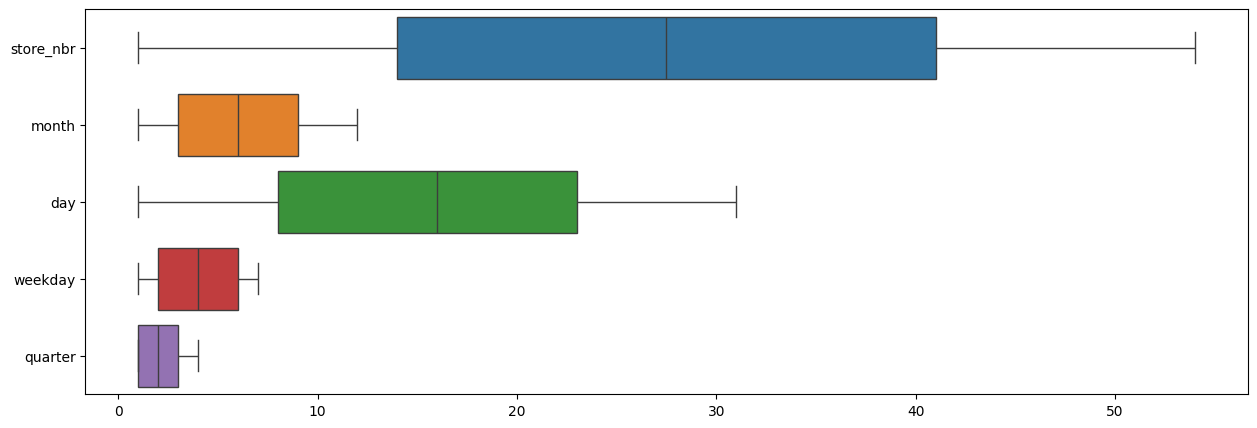

In [52]:
plt.figure(figsize = (15,5))
snl.boxplot(train_df.drop(['year', 'sales', 'onpromotion', 'family']), orient = 'h')
plt.show()

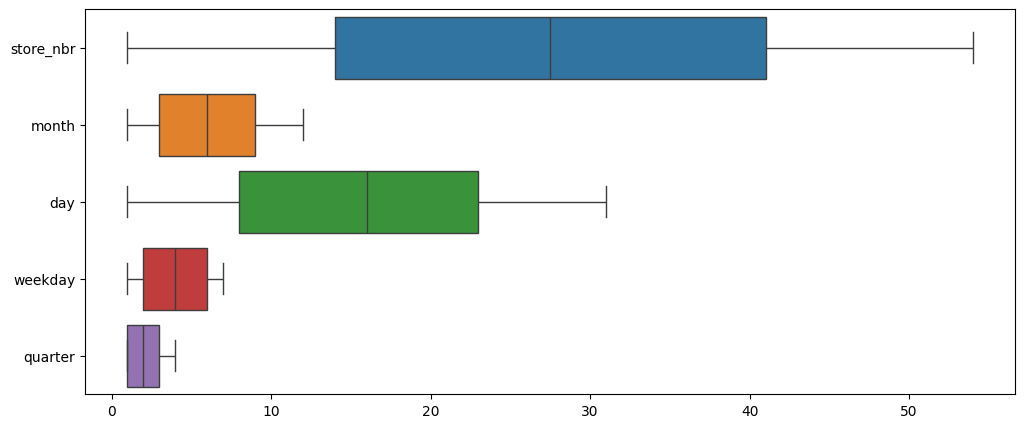

In [53]:
# Select columns to keep for the boxplot
columns_to_keep = [col for col in train_df.columns if col not in ['year', 'sales', 'onpromotion', 'family']]
df_for_boxplot = train_df.select(columns_to_keep)

# Plotting the boxplot
plt.figure(figsize=(12, 5))
snl.boxplot(df_for_boxplot, orient='h')
plt.show()

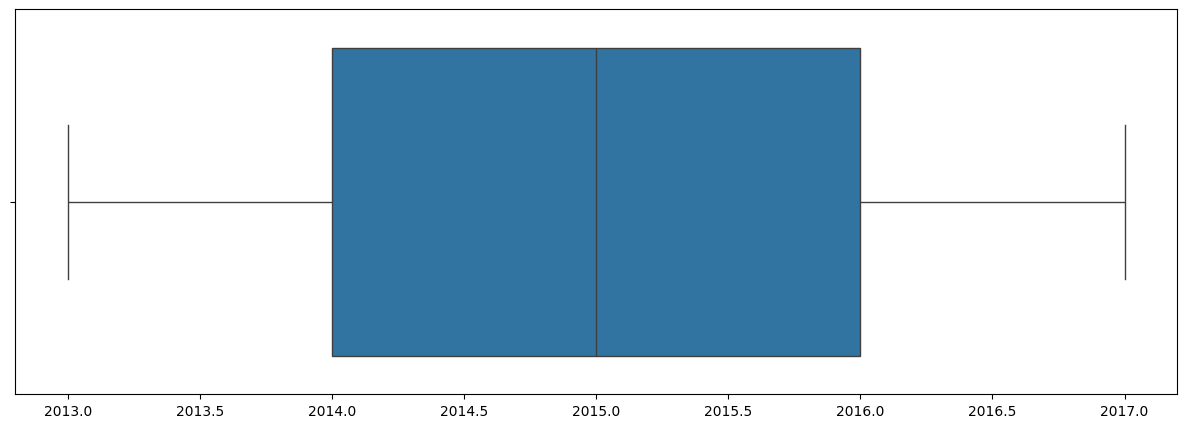

In [54]:
plt.figure(figsize = (15,5))
snl.boxplot(train_df['year'], orient = 'h')
plt.show()

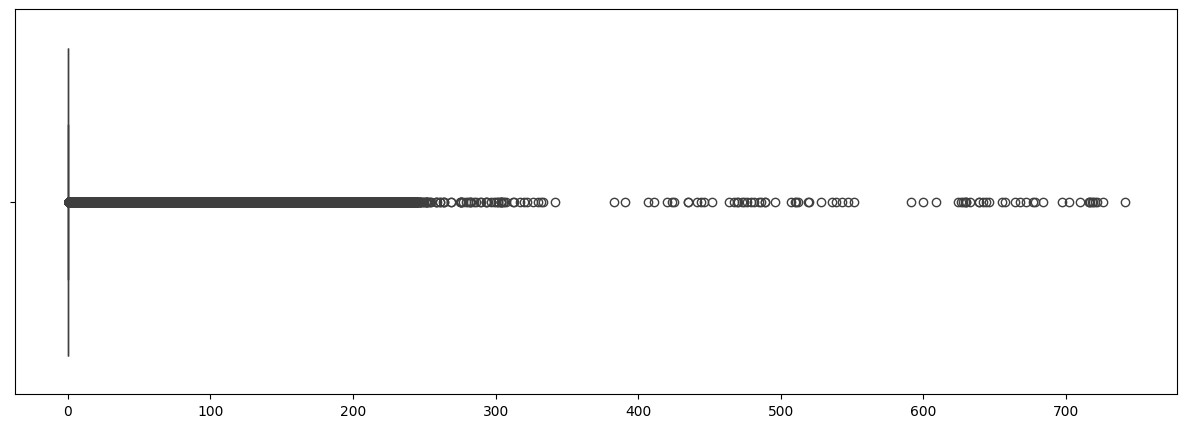

In [55]:
plt.figure(figsize = (15,5))
snl.boxplot(train_df['onpromotion'], orient = 'h')
plt.show()

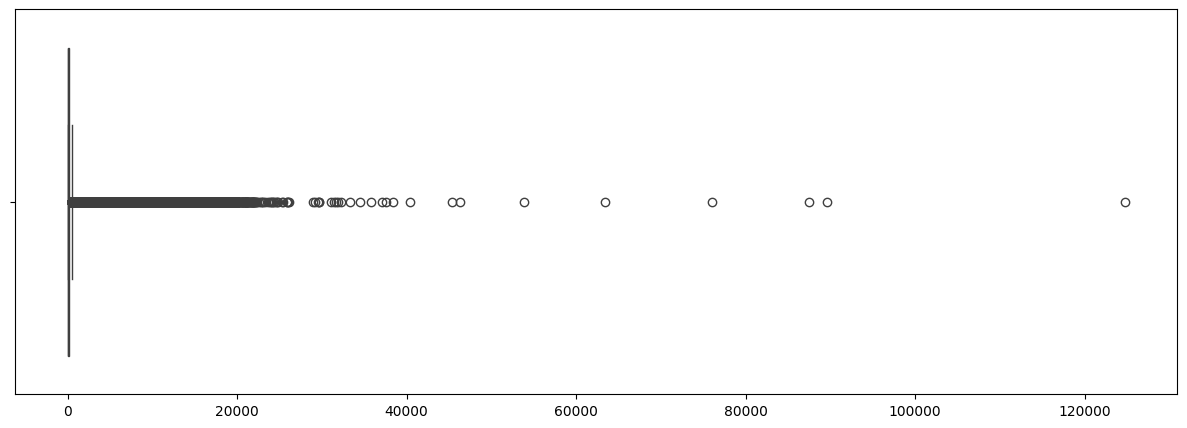

In [56]:
plt.figure(figsize = (15,5))
snl.boxplot(train_df['sales'], orient = 'h')
plt.show()

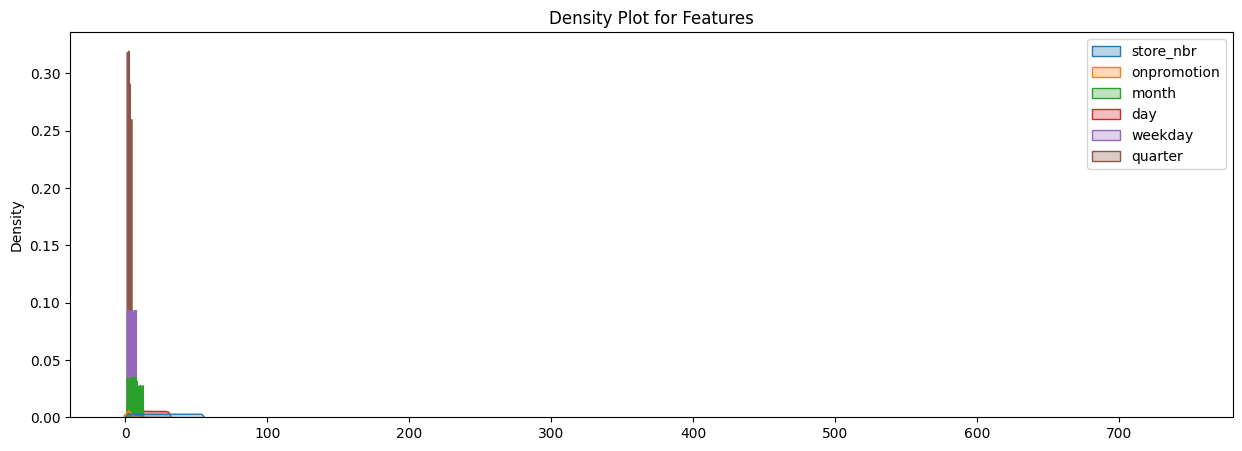

In [57]:
plt.figure(figsize=(15, 5))
snl.kdeplot(train_df.drop(columns=['year', 'sales']), alpha=0.3, fill=True)
plt.title('Density Plot for Features')
plt.show()

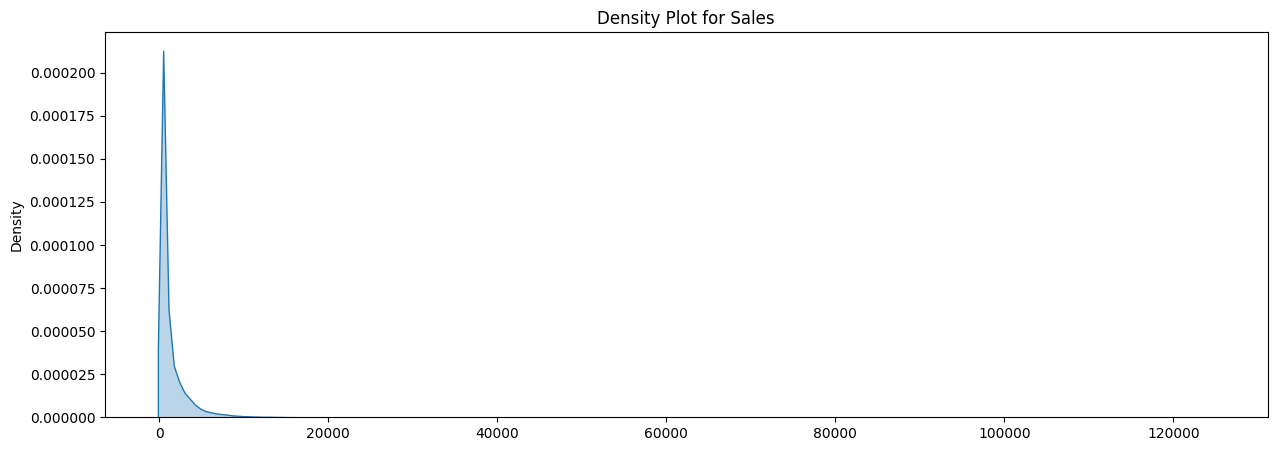

In [58]:
plt.figure(figsize=(15, 5))
snl.kdeplot(train_df['sales'], alpha=0.3, fill=True)
plt.title('Density Plot for Sales')
plt.show()

In [59]:
sales_skew = train_df['sales'].skew()
onpromotion_skew = train_df['onpromotion'].skew()
store_skew = train_df['store_nbr'].skew()
date_skew = train_df['date'].skew()

print(f'Sales skewness = {sales_skew}')
print(f'onpromotion skewness = {onpromotion_skew}')
print(f'Store skewness = {store_skew}')
print(f'Date skewness = {date_skew}')

Sales skewness = 7.366958233475781
onpromotion skewness = 11.179500598595624
Store skewness = 0.0
Date skewness = 0.0


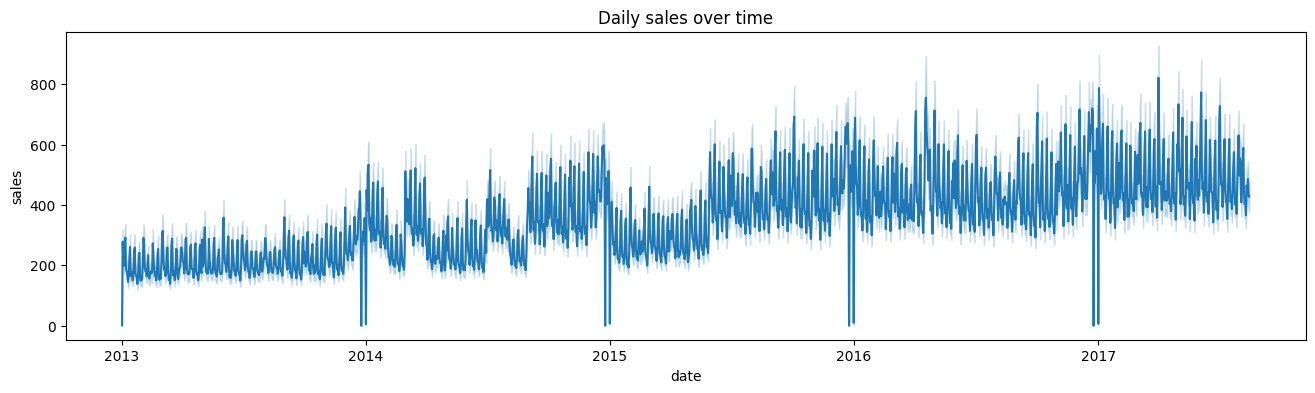

In [60]:
plt.figure(figsize=(16, 4)) 
sns.lineplot(train_df, x=train_df['date'], y=train_df['sales'])
plt.title(f'Daily sales over time')
plt.show()

## **Bi-Variate Analysis**

Exploring relationships

In [61]:
train_df_numeric = train_df.select(pl.selectors.by_dtype(pl.Date, pl.INTEGER_DTYPES, pl.FLOAT_DTYPES))

# Getting the correlation of numeric values in the train dataset
correlation = train_df_numeric.corr()

# Create the heatmap using Plotly Express
fig = px.imshow(correlation,
                labels=dict(color="Correlation"),
                x=correlation.columns,
                y=correlation.columns,
                text_auto=True,  # Automatically add text in each cell
)

# Update layout for better readability
fig.update_layout(title="Correlation Heatmap", height=700)

# Set the size of text annotations
fig.update_traces(
    text=correlation.to_numpy(),
    texttemplate="%{text:.4f}",
    textfont_size=12
)

fig.show()

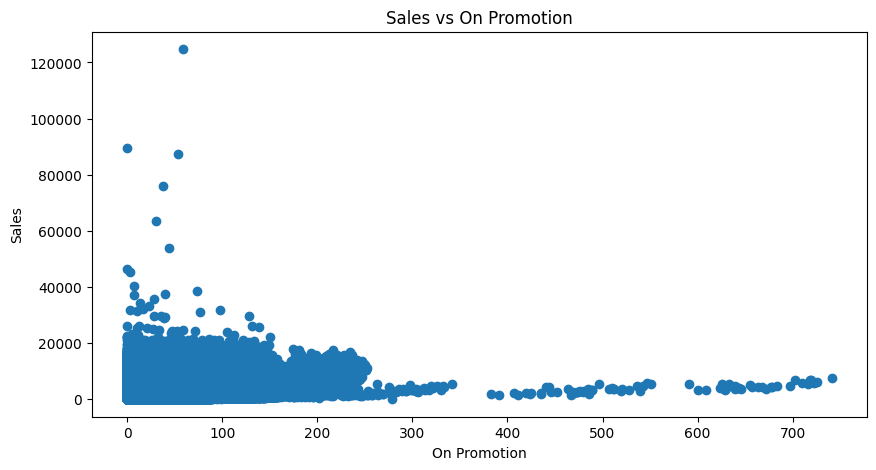

In [62]:
# Visualize relationships between sales and promotion
plt.figure(figsize=(10,5))
plt.scatter(train_df['onpromotion'], train_df['sales'])
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.title('Sales vs On Promotion')
plt.show()

Decompostion

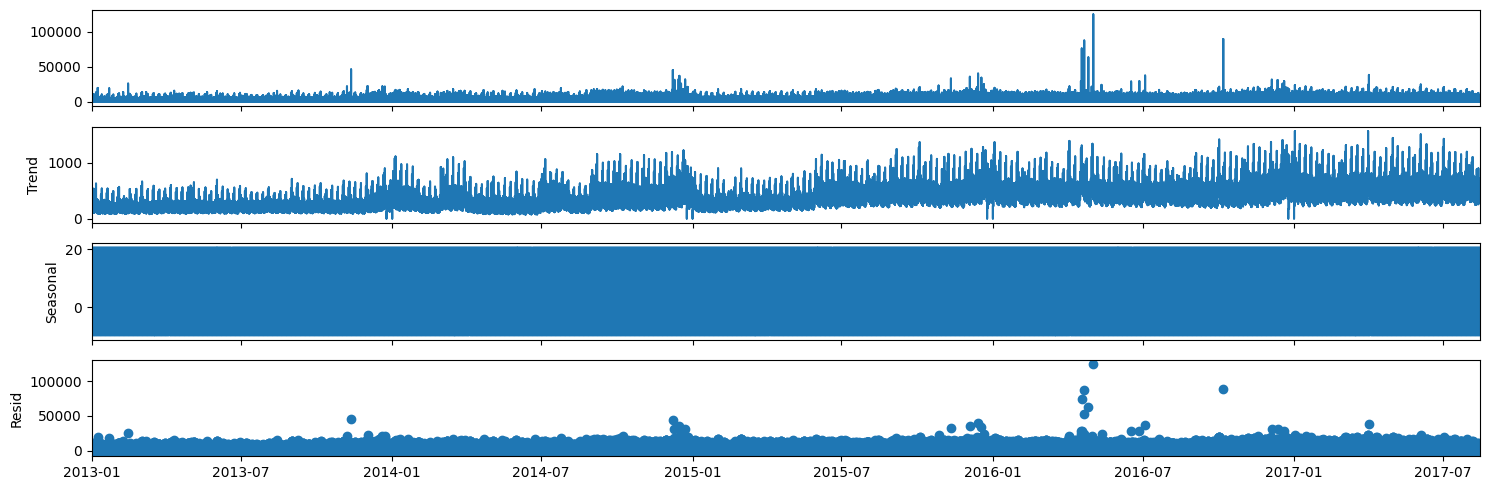

In [63]:
# Creating a data frame for sales and date to use for decomposition
seasonal_df = train_df[['date', 'sales']].to_pandas() 

# Setting the date as the index
seasonal_df.set_index('date', inplace=True)

# Using additive model, calculate the additive results for seasons, trends and noise for the sales
additive_results = seasonal_decompose(seasonal_df, model = 'additive', period = 365)

# Update rcParams to set the figure size for the plot
plt.rcParams.update({'figure.figsize': (15, 5)})

# Plot the decomposed components (trend, seasonal, residual)
additive_results.plot()

# Display the plot
plt.show()

In [64]:
# Extract components and create a new DataFrame
decomposition_df = pl.DataFrame({
        'Trend': additive_results.trend,
        'Seasonality': additive_results.seasonal,
        'Residual': additive_results.resid,
        'Observed': additive_results.observed,
            
            }) 
decomposition_df

shape: (3_008_016, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Trend ‚îÜ Seasonality ‚îÜ Residual ‚îÜ Observed ‚îÇ
‚îÇ ---   ‚îÜ ---         ‚îÜ ---      ‚îÜ ---      ‚îÇ
‚îÇ f64   ‚îÜ f64         ‚îÜ f64      ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ null  ‚îÜ 3.132589    ‚îÜ null     ‚îÜ 0.0      ‚îÇ
‚îÇ null  ‚îÜ 3.245342    ‚îÜ null     ‚îÜ 0.0      ‚îÇ
‚îÇ null  ‚îÜ 0.063797    ‚îÜ null     ‚îÜ 0.0      ‚îÇ
‚îÇ null  ‚îÜ -4.472616   ‚îÜ null     ‚îÜ 0.0      ‚îÇ
‚îÇ null  ‚îÜ -2.799327   ‚îÜ null     ‚îÜ 0.0      ‚îÇ
‚îÇ ‚Ä¶     ‚îÜ ‚Ä¶           ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ null  ‚îÜ -2.939043   ‚îÜ null     ‚îÜ 438.133  ‚îÇ
‚îÇ null  ‚îÜ 0.677141    ‚îÜ null     ‚îÜ 154.553  ‚îÇ
‚îÇ null  ‚îÜ 1.958825    ‚îÜ null     ‚îÜ 2419.729 ‚îÇ
‚îÇ null  ‚îÜ 9.883064    ‚îÜ null     ‚îÜ 121.0    ‚îÇ
‚îÇ null  ‚îÜ -1.308789   ‚îÜ null     ‚îÜ 16.0     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Stationarity Test using Augmented Dickey-Fuller(ADF) test

In [65]:
# Resampling the data to weekly and getting the average
resampled_df = train_df.group_by_dynamic("date", every="1w").agg(pl.col("sales").mean())

resampled_df.shape

(242, 2)

In [66]:
# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(resampled_df['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Perform differencing if needed for stationarity
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")


ADF Statistic: -1.4817509177560266
p-value: 0.542518811098264
Data is not stationary


Visualization of the Stationarity using Rolling statistics

In [67]:
# Getting the rolling Average
rolling_average = train_df.rolling(index_column="date", period="1w").agg(pl.mean("sales").alias("sales_average"))

# Getting the rolling Standard Deviation
rolling_std = train_df.rolling(index_column="date", period="1w").agg(pl.std("sales").alias("sales_std"))

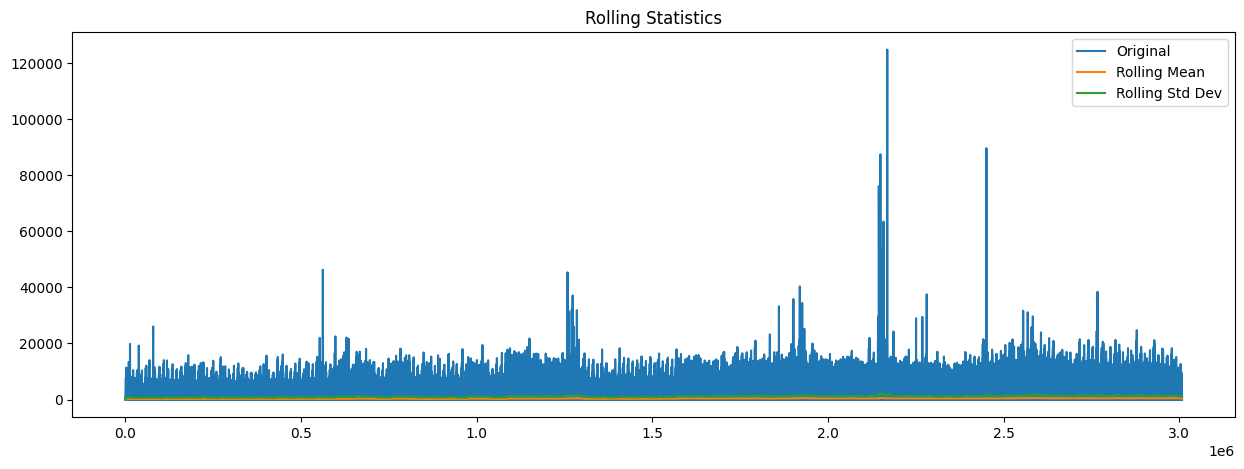

In [68]:
# Create both figure and axis objects
fig, ax = plt.subplots(figsize=(15, 5))
 
# Make plot
ax.plot(train_df['sales'], label = 'Original')
ax.plot(rolling_average['sales_average'], label = 'Rolling Mean')
ax.plot(rolling_std['sales_std'], label = 'Rolling Std Dev')
ax.legend(loc = 'best')
ax.set_title("Rolling Statistics")

# Show the plot
plt.show()

### **Answering the Business Analytical Questions**

Question 1. Is the train dataset complete (has all the required dates)?

In [69]:
# Calling my missing_dates function with train_df 
missing_dates_df = missing_dates(train_df)

# Print message
if missing_dates_df.shape[0] == 0:
    print("The train dataset is complete for all the required dates.")
else:
    print("The train dataset is not complete for all required dates.")
    print("Missing dates:")
    print(missing_dates_df)

The train dataset is complete for all the required dates.


This question has been addressed in the EDA of the train dataset. After conducting a comprehensive analysis, I discovered that four dates were missing. These have been filled with a constant sales value of 0.0, as the stores were closed on these days.

Question 2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

In [70]:
# Define the years for which you want to filter the data
years = [2013, 2014, 2015, 2016, 2017]

# Initialize empty lists to store filtered DataFrames and highest/lowest sales for each year
filtered_dfs = []
highest_sales = []
lowest_sales = []

# Loop through each year to filter data and calculate highest/lowest sales
for year in years:
    # Filter the train dataframe for the specific year
    filtered_df = train_df.filter(pl.col('year') == year)
    
    # Filter the train dataframe to get the values that do not include the days when the store was closed
    filtered_df = filtered_df.filter(pl.col('sales') != 0.0)
    
    # Calculate the highest sales values by getting the top 5 values and sorting in descending order
    highest_sales_df = filtered_df[['sales', 'date']].sort('sales', descending=True).top_k(5, by='sales')
    
    # Calculate the lowest sales values by getting the bottom 5 values and sorting in ascending order
    lowest_sales_df = filtered_df[['sales', 'date']].sort('sales', descending = True).bottom_k(5, by='sales')
    
    # Append the filtered DataFrame and highest/lowest sales DataFrames to the respective lists
    filtered_dfs.append(filtered_df)
    highest_sales.append(highest_sales_df)
    lowest_sales.append(lowest_sales_df)

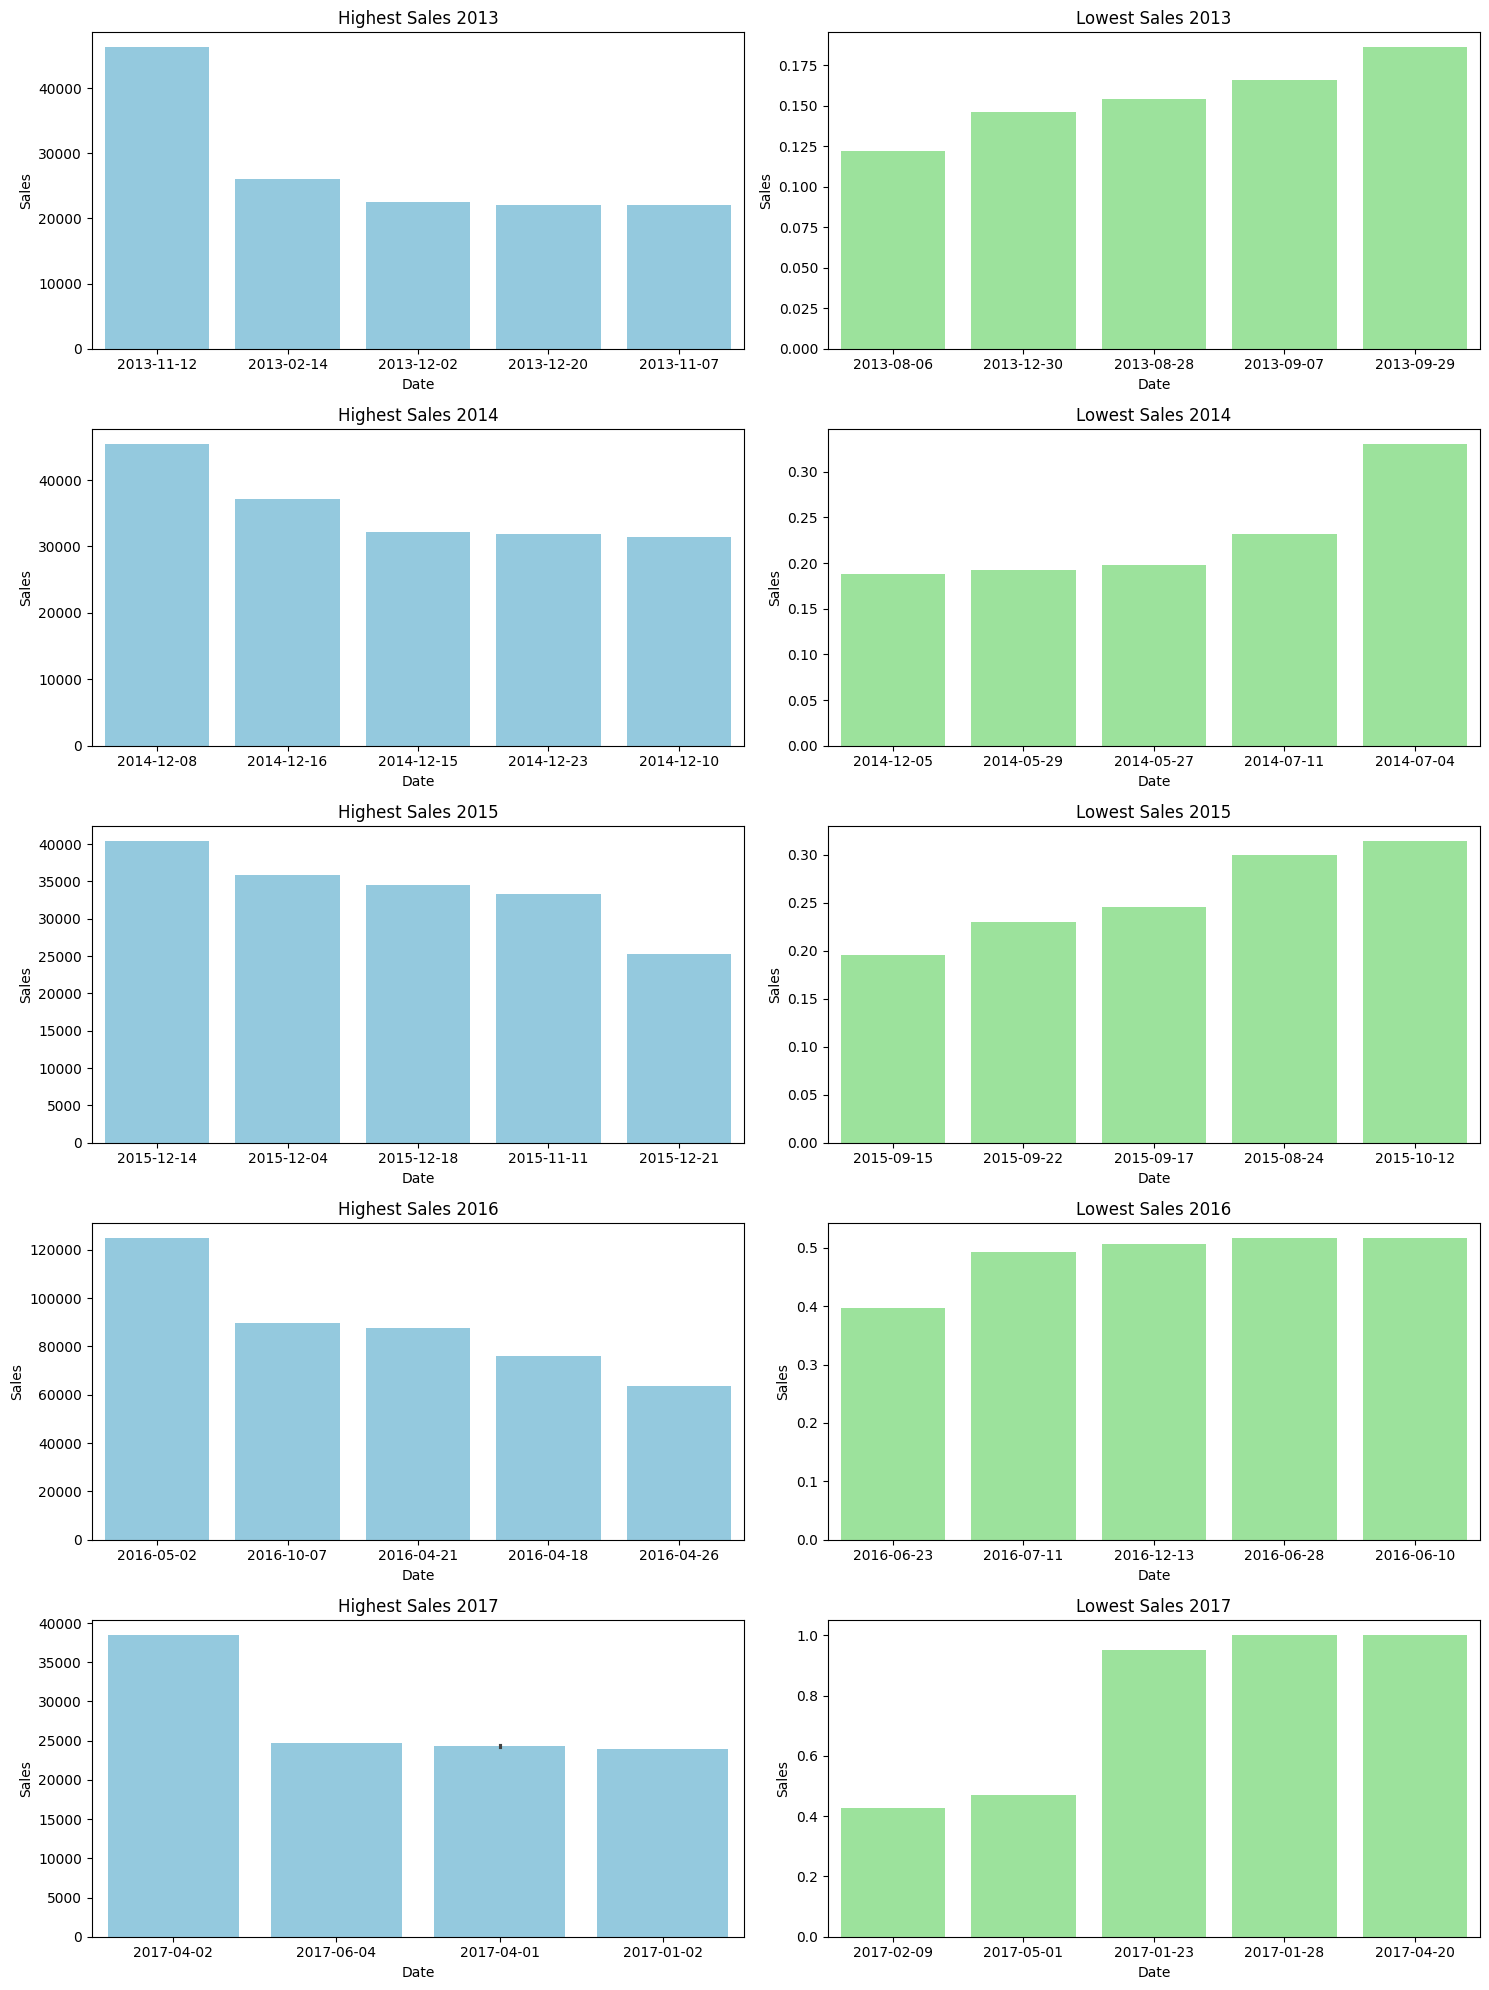

In [71]:
# Create subplots for each year (two subplots per year)
fig, axs = plt.subplots(len(years), 2, figsize=(15, 20))

# Loop through the years to plot side-by-side bar graphs for highest and lowest sales
for i, year in enumerate(years):
    # Plotting bar graph for highest sales on the left
    sns.barplot(x='date', y='sales', data=highest_sales[i], ax=axs[i, 0], color='skyblue')
    axs[i, 0].set_title(f'Highest Sales {year}')

    # Set labels for x and y axes
    axs[i, 0].set_xlabel('Date')
    axs[i, 0].set_ylabel('Sales')

    # Plotting bar graph for lowest sales on the right
    sns.barplot(x='date', y='sales', data=lowest_sales[i], ax=axs[i, 1], color='lightgreen')
    axs[i, 1].set_title(f'Lowest Sales {year}')

    # Set labels for x and y axes
    axs[i, 1].set_xlabel('Date')
    axs[i, 1].set_ylabel('Sales')

plt.tight_layout()
plt.show()

Question 3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

In [74]:
sales_2013 = train_df.filter(train_df['year'] == 2013)
sales_by_month_2013 = sales_2013.groupby('month').agg(pl.col("sales").sum())

sales_2014 = train_df.filter(train_df['year'] == 2014)
sales_by_month_2014 = sales_2014.groupby('month').agg(pl.col("sales").sum())

sales_2015 = train_df.filter(train_df['year'] == 2015)
sales_by_month_2015 = sales_2015.groupby('month').agg(pl.col("sales").sum())

sales_2016 = train_df.filter(train_df['year'] == 2016)
sales_by_month_2016 = sales_2016.groupby('month').agg(pl.col("sales").sum())

sales_2017 = train_df.filter(train_df['year'] == 2017)
sales_by_month_2017 = sales_2017.groupby('month').agg(pl.col("sales").sum())

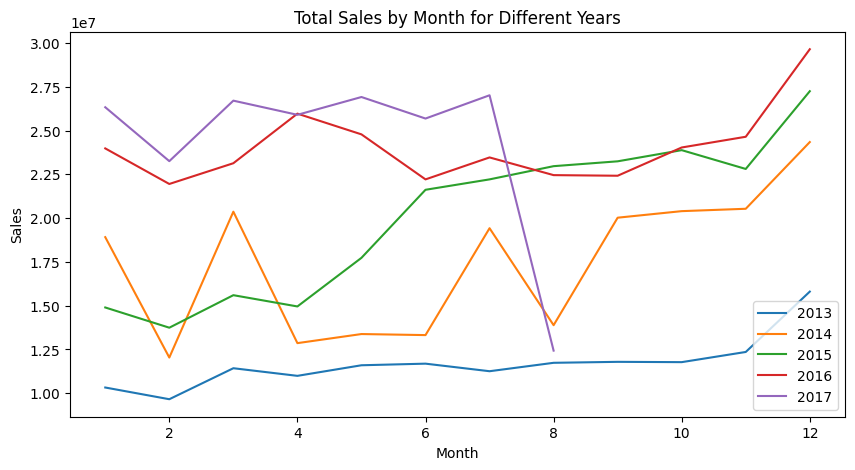

In [101]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=sales_by_month_2013, x='month', y='sales', label='2013')
sns.lineplot(data=sales_by_month_2014, x='month', y='sales', label='2014')
sns.lineplot(data=sales_by_month_2015, x='month', y='sales', label='2015')
sns.lineplot(data=sales_by_month_2016, x='month', y='sales', label='2016')
sns.lineplot(data=sales_by_month_2017, x='month', y='sales', label='2017')

plt.legend()
plt.title('Total Sales by Month for Different Years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()  

Question 4. Did the earthquake impact sales?

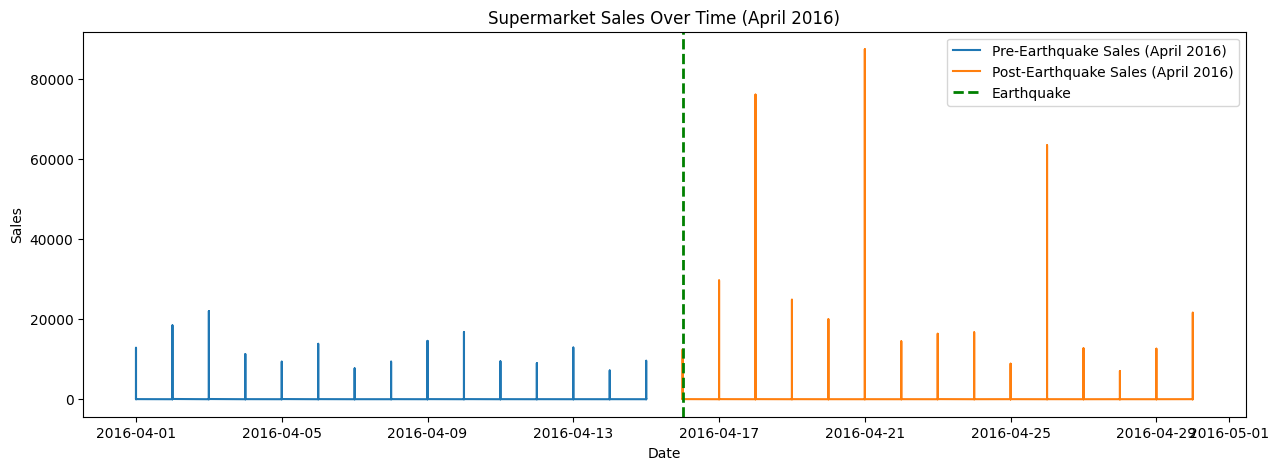

In [77]:
# Filter data for the period before and after the earthquake in April 2016
pre_earthq_april_2016 = train_df.filter(
    (train_df['date'] < pl.date(2016, 4, 16)) & (train_df['year'] == 2016) & (train_df['month'] == 4)
)
post_earthq_april_2016 = train_df.filter(
    (train_df['date'] >= pl.date(2016, 4, 16)) & (train_df['year'] == 2016) & (train_df['month'] == 4)
)

# Convert Polars DataFrame back to pandas DataFrame for plotting
pre_earthq_april_2016 = pre_earthq_april_2016.to_pandas()
post_earthq_april_2016 = post_earthq_april_2016.to_pandas()

# Plot sales over time using Matplotlib
plt.figure(figsize=(15, 5))
plt.plot(pre_earthq_april_2016['date'], pre_earthq_april_2016['sales'], label='Pre-Earthquake Sales (April 2016)')
plt.plot(post_earthq_april_2016['date'], post_earthq_april_2016['sales'], label='Post-Earthquake Sales (April 2016)')

# Earthquake date
earthq_date = '2016-04-16'

# Convert the earthquake date to a matplotlib-compatible format
earthq_num = mdates.datestr2num(earthq_date)

# Add a vertical line at the date of the earthquake
plt.axvline(x=earthq_num, color='green', linestyle='--', linewidth=2, label='Earthquake')

plt.title('Supermarket Sales Over Time (April 2016)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [78]:
# Perform a t-test to compare sales before and after the earthquake
t_stat, p_value = ttest_ind(pre_earthq_april_2016['sales'], post_earthq_april_2016['sales'])
 
# Significance level
alpha = 0.05
 
if p_value < alpha:
    print(f"The difference in sales before and after the earthquake is statistically significant (p-value = {p_value}).")
else:
    print(f"There is no statistically significant difference in sales before and after the earthquake (p-value = {p_value}).")

The difference in sales before and after the earthquake is statistically significant (p-value = 2.4603666717106278e-08).


Question 5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

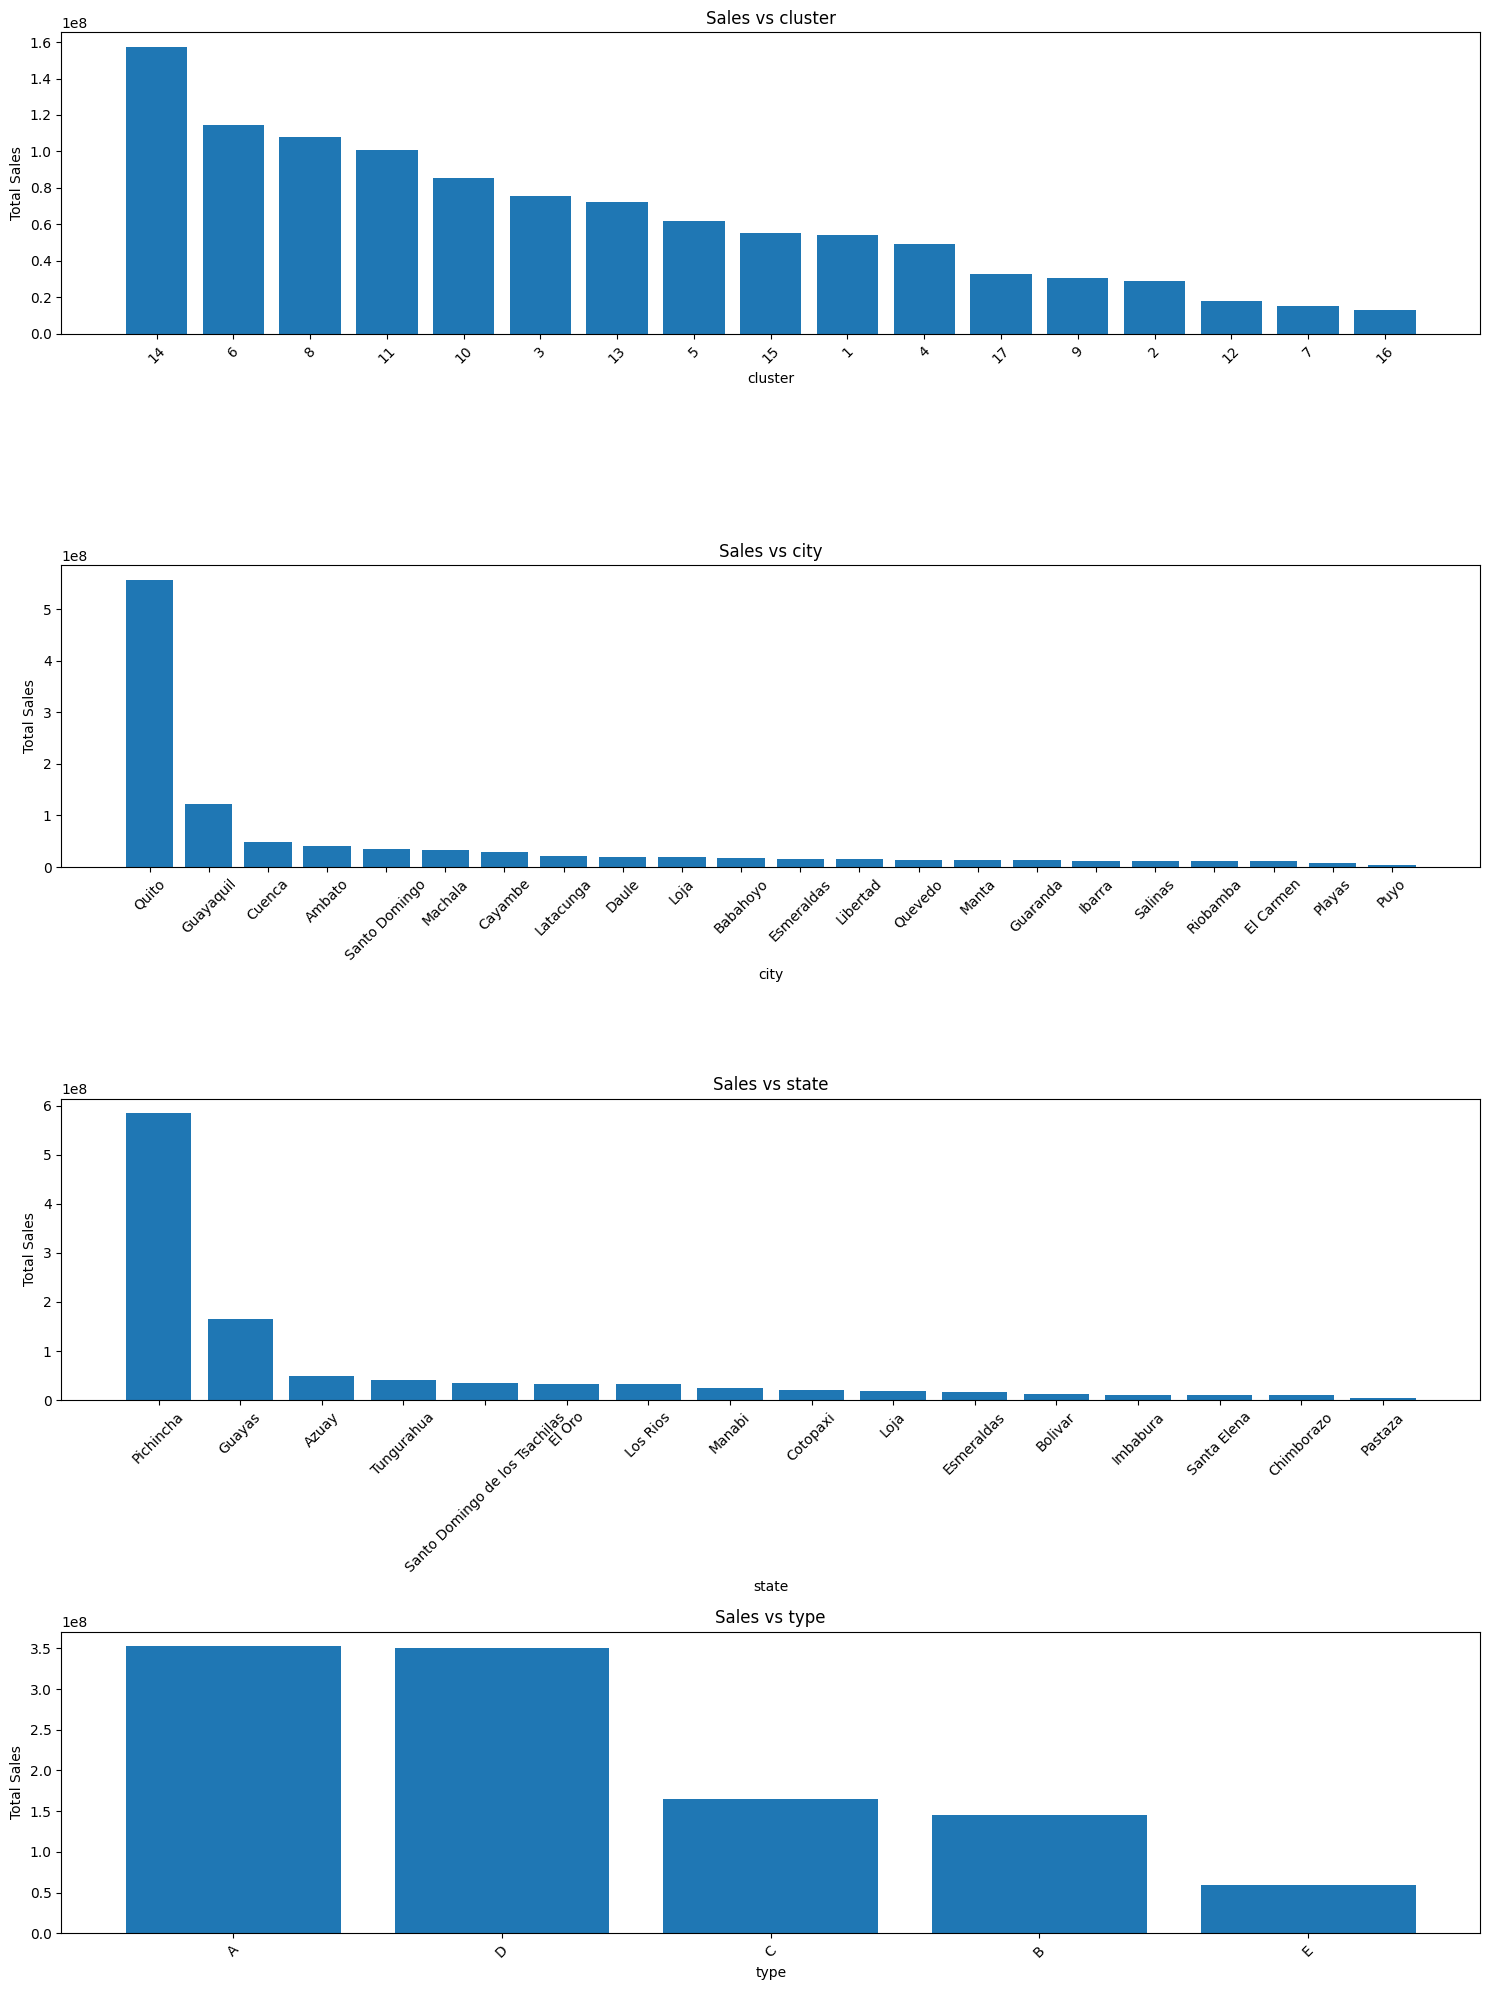

In [66]:
# Merge Store data to previous merged data on store_nbr column
train_store_df = train_df.join(stores_df, on='store_nbr')

group_by_columns = ['cluster', 'city', 'state', 'type']

fig, axs = plt.subplots(len(group_by_columns), 1, figsize=(15, 5 * len(group_by_columns)))

for idx, column in enumerate(group_by_columns):
    grouped_sales = train_store_df.groupby(column).agg(pl.sum('sales').alias('total_sales')).sort('total_sales', descending=True)
    grouped_sales = grouped_sales.with_columns(pl.col(column).cast(pl.String))  # Casting the column to string
    
    # Plotting the visualization on its own subplot
    axs[idx].bar(grouped_sales[column], grouped_sales['total_sales'])
    axs[idx].set_xlabel(column)
    axs[idx].set_ylabel('Total Sales')
    axs[idx].set_title(f'Sales vs {column}')
    axs[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Question 6. Are sales affected by promotions, oil prices and holidays?

Checking for missing dates in the oil data frame

In [80]:
# Calling my start_end_date function on my oil df
start_date, end_date = start_end_date(oil_df)

Start date is 2013-01-01
End date is 2017-08-31


In [81]:
# Calling my function for missing dates to check if there are missing dates in my oil df
all_missing_dates = missing_dates(oil_df)
all_missing_dates.head(2)

shape: (2,)
Series: 'literal' [date]
[
	2013-01-05
	2013-01-06
]

In [82]:
# Creating a dataframe to store my missing values
missing_df = pl.DataFrame()
missing_df = missing_df.with_columns(
    date=all_missing_dates,
    dcoilwtico=None,
)

missing_df.glimpse()

Rows: 486
Columns: 2
$ date       <date> 2013-01-05, 2013-01-06, 2013-01-12, 2013-01-13, 2013-01-19, 2013-01-20, 2013-01-26, 2013-01-27, 2013-02-02, 2013-02-03
$ dcoilwtico <null> None, None, None, None, None, None, None, None, None, None



In [83]:
# Concating my original oil_df with missing_df
oil_df = oil_df.vstack(missing_df).sort('date')
oil_df.glimpse()


Rows: 1704
Columns: 2
$ date       <date> 2013-01-01, 2013-01-02, 2013-01-03, 2013-01-04, 2013-01-05, 2013-01-06, 2013-01-07, 2013-01-08, 2013-01-09, 2013-01-10
$ dcoilwtico  <f64> None, 93.13999938964844, 92.97000122070312, 93.12000274658203, None, None, 93.19999694824219, 93.20999908447266, 93.08000183105469, 93.80999755859375



In [84]:
#  Checking again to confirm there are no more missing dates in the oil df by calling the missing dates function
all_missing_dates = missing_dates(oil_df)
all_missing_dates

shape: (0,)
Series: 'literal' [date]
[
]

In [85]:
# Forward fill missing values in the 'dcoilwtico' column
oil_df = oil_df.fill_null(strategy="forward")

In [86]:
# Backward fill missing value in the 'dcoilwtico' column
oil_df = oil_df.fill_null(strategy="backward")

In [87]:
oil_df.null_count()

shape: (1, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date ‚îÜ dcoilwtico ‚îÇ
‚îÇ ---  ‚îÜ ---        ‚îÇ
‚îÇ u32  ‚îÜ u32        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 0          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Merging the oil_df and the Holiday_events_df with train_df

In [65]:
# Merge Holiday data to train data on date column
train_holiday_df = train_df.join(holiday_events_df, on='date')
# Merge Oil data to previous merged data on date column
train_holiday_oil_df = train_holiday_df.join(oil_df, on='date')
train_holiday_oil_df.head(1)

shape: (1, 16)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ store_nbr ‚îÜ family     ‚îÜ sales ‚îÜ ‚Ä¶ ‚îÜ locale_nam ‚îÜ descripti ‚îÜ transferr ‚îÜ dcoilwtic ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---        ‚îÜ ---   ‚îÜ   ‚îÜ e          ‚îÜ on        ‚îÜ ed        ‚îÜ o         ‚îÇ
‚îÇ date       ‚îÜ i64       ‚îÜ str        ‚îÜ f64   ‚îÜ   ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ str        ‚îÜ str       ‚îÜ bool      ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ 1         ‚îÜ AUTOMOTIVE ‚îÜ 0.0   ‚îÜ ‚Ä¶ ‚îÜ Ecuador    ‚îÜ Primer    ‚îÜ false     ‚îÜ null      ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ dia del   ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ ano       ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Oil prices Vs sales

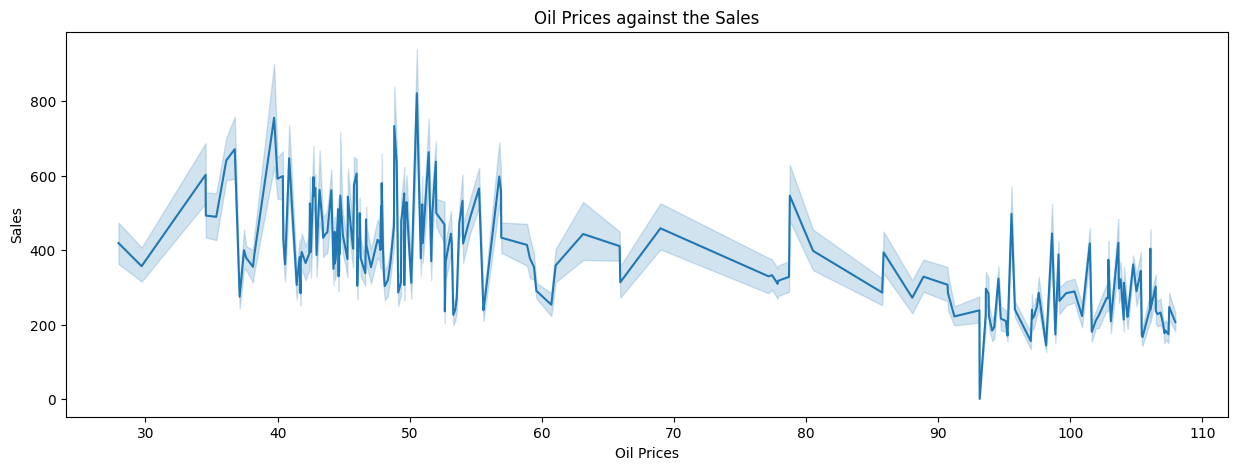

In [89]:
plt.figure(figsize = (15,5))

# Visualiza the data
sns.lineplot(data = train_holiday_oil_df, x='dcoilwtico', y='sales')
plt.title('Oil Prices against the Sales')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')

plt.show()

Holidays Vs sales

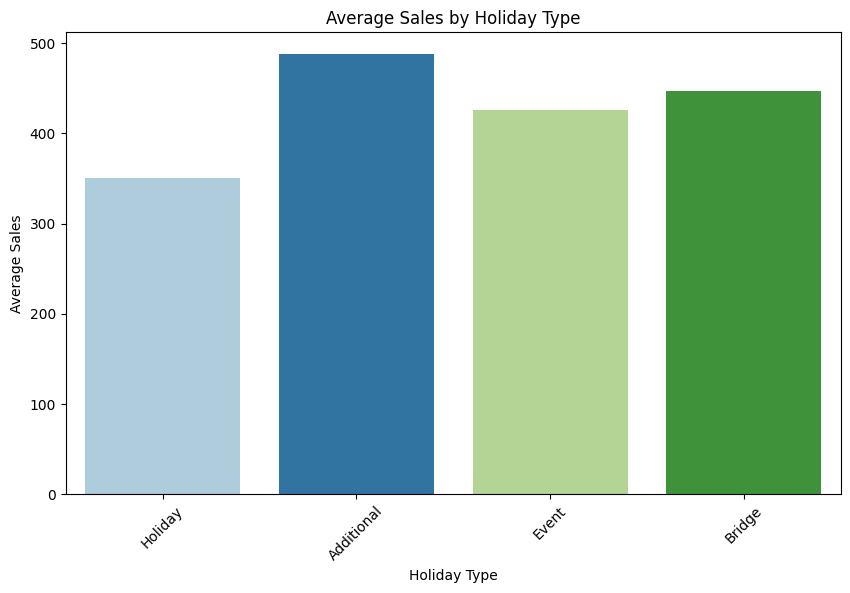

In [90]:
# Filter data for holidays (excluding transfers)
holiday_types = ['Holiday', 'Bridge', 'Additional', 'Event']
holiday_data = train_holiday_oil_df.filter(pl.col('type').is_in(holiday_types))

# Group data by holiday type and calculate average sales
avg_sales_by_type = holiday_data.groupby('type').agg(pl.mean('sales')).select('type', pl.col('sales').alias('sales_mean'))

# Convert Polars DataFrame to pandas DataFrame for plotting with Seaborn
avg_sales_by_type_df = avg_sales_by_type.to_pandas()


# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='sales_mean', data=avg_sales_by_type, palette='Paired')
plt.title('Average Sales by Holiday Type')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()

Promotions Vs Sales

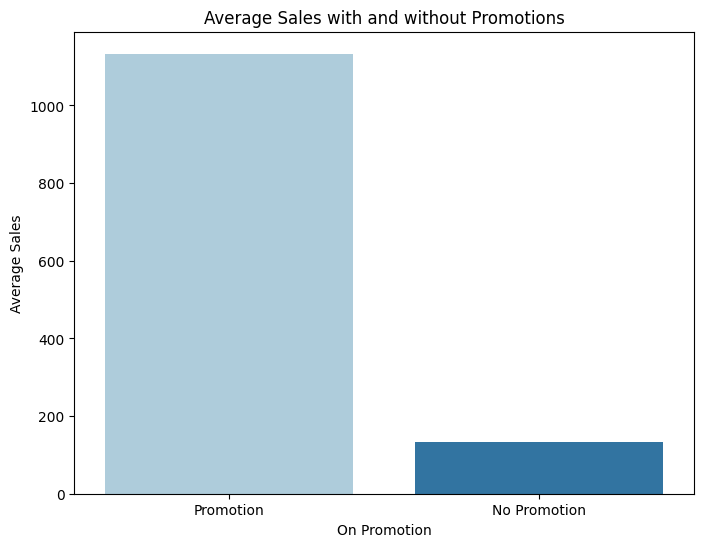

In [67]:
# Filter data for promotions and no promotions
promotions_data = train_holiday_oil_df.filter(train_holiday_oil_df['onpromotion'] > 0)['sales']
no_promotions_data = train_holiday_oil_df.filter(train_holiday_oil_df['onpromotion'] == 0)['sales']

# Create the line plot
plt.figure(figsize=(8, 6))
sns.barplot(x=['Promotion', 'No Promotion'], y=[promotions_data.mean(), no_promotions_data.mean()], palette='Paired')
plt.title('Average Sales with and without Promotions')
plt.xlabel('On Promotion')
plt.ylabel('Average Sales')
plt.show()

Question 7. What analysis can we get from the date and its extractable features?

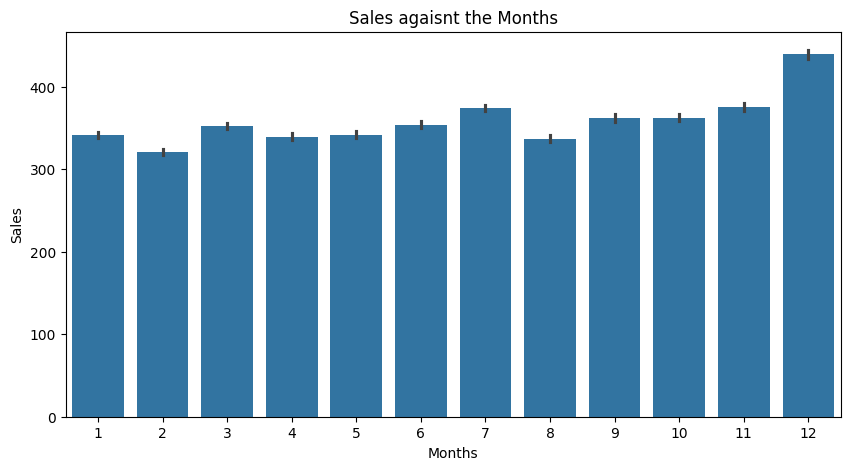

In [92]:
# Plotting the sales against the months
plt.figure(figsize = (10,5))
sns.barplot(data = train_df, x='month', y='sales')
plt.title('Sales agaisnt the Months')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.show()

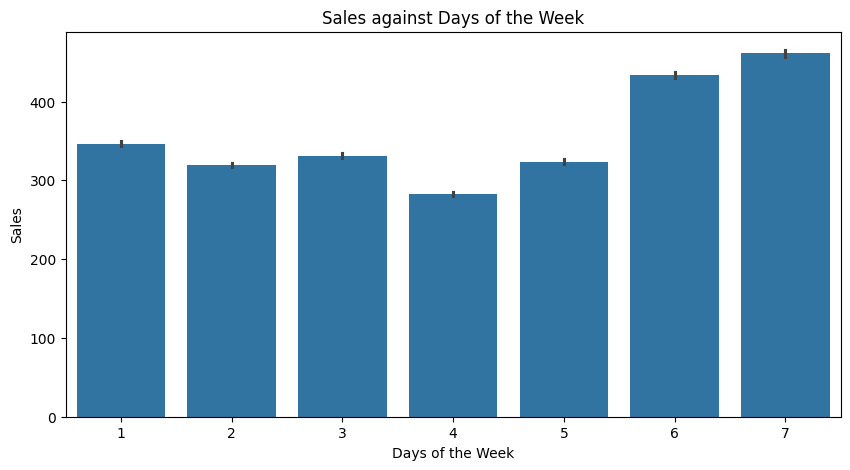

In [93]:
# Plotting the sales against the weekdays
plt.figure(figsize = (10,5))
sns.barplot(data = train_df, x='weekday', y='sales')
plt.title('Sales against Days of the Week')
plt.xlabel('Days of the Week')
plt.ylabel('Sales')
plt.show()

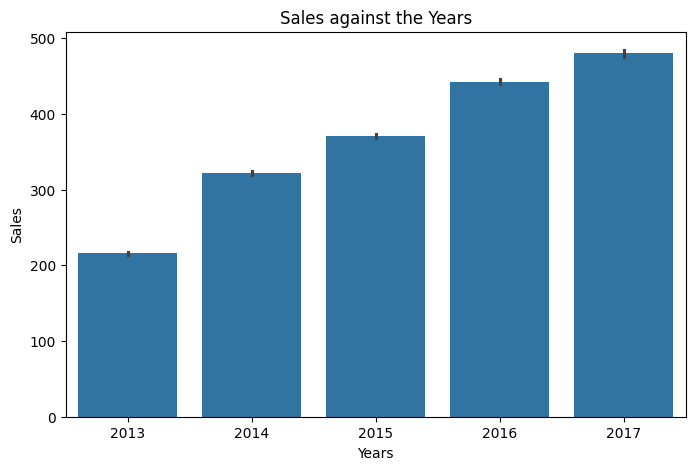

In [94]:
# Plotting the sales against the years
plt.figure(figsize = (8,5))
sns.barplot(data = train_df, x='year', y='sales')
plt.title('Sales against the Years')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.show()

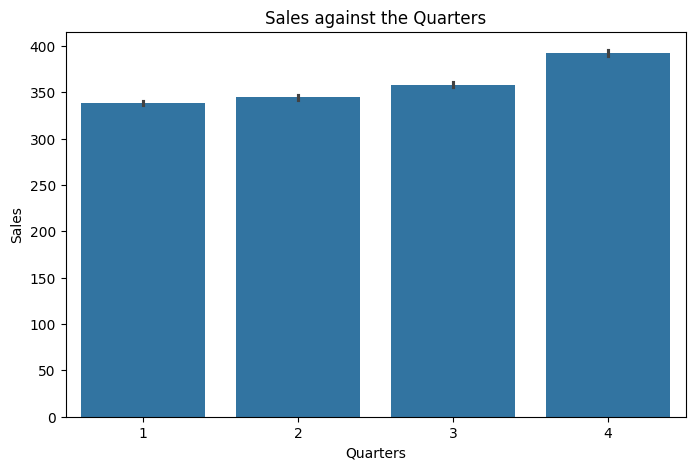

In [95]:
# Plotting the sales against the quarters
plt.figure(figsize = (8,5))
sns.barplot(data = train_df, x='quarter', y='sales')
plt.title('Sales against the Quarters')
plt.xlabel('Quarters')
plt.ylabel('Sales')
plt.show()

Question 8. Which product family and stores did the promotions affect.

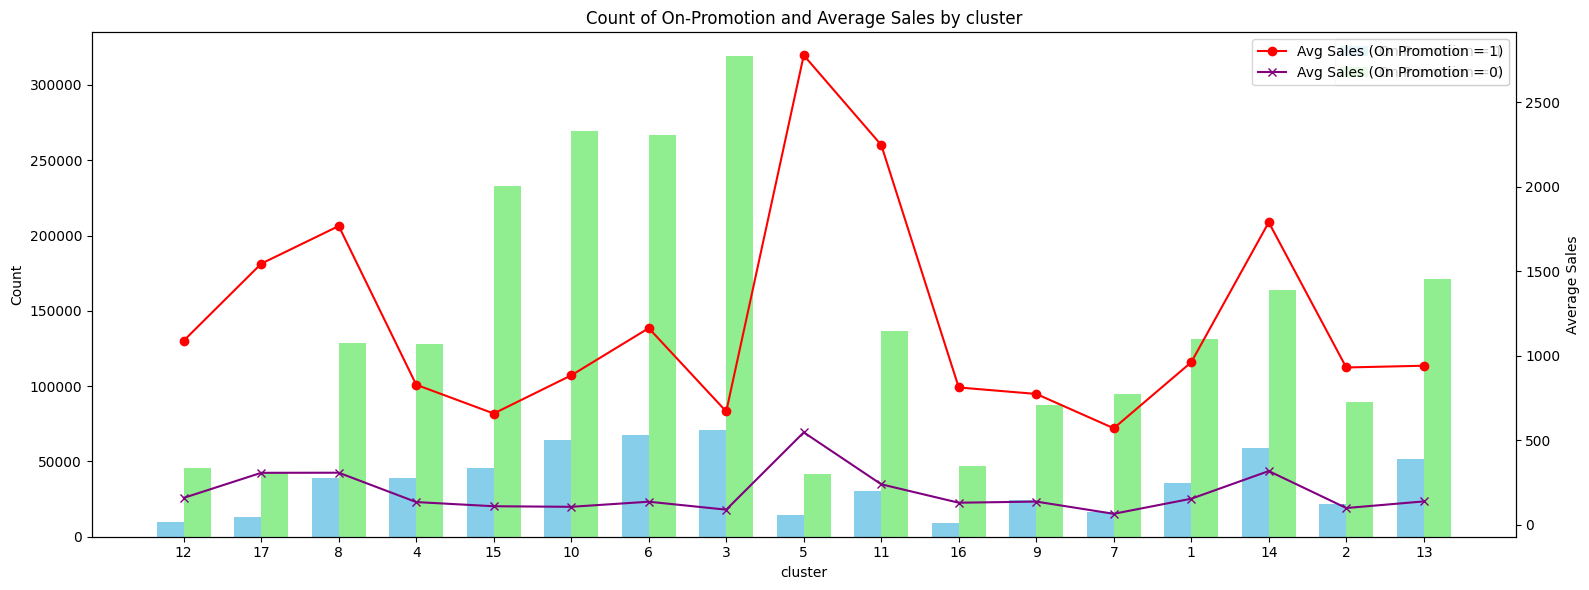

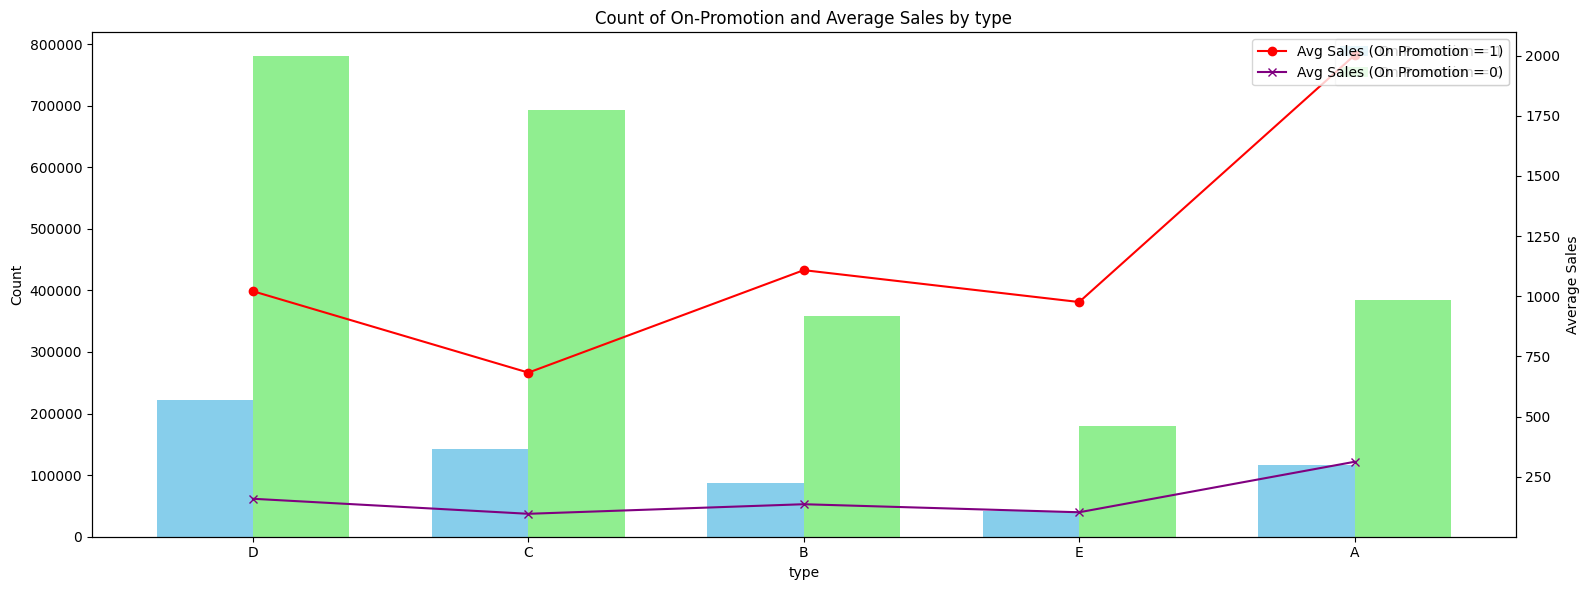

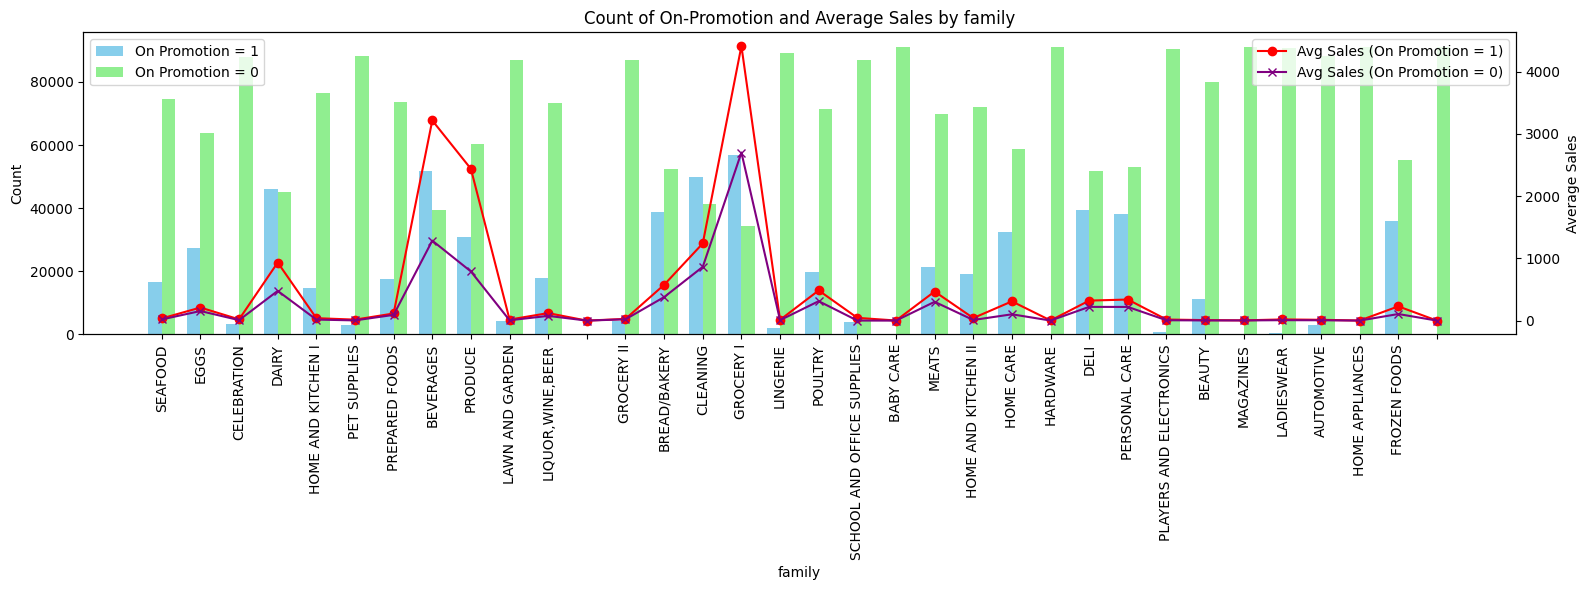

In [68]:
group = ['cluster', 'type', 'family']
for g in group:
    # Filter data for onpromotion > 0 and onpromotion = 0
    onpromotion_1 = train_store_df.filter(pl.col('onpromotion') > 0)
    onpromotion_0 = train_store_df.filter(pl.col('onpromotion') == 0)
 
    # Group data and count occurrences for onpromotion > 0 and onpromotion = 0
    onpromotion_1_counts = onpromotion_1.groupby(g).agg(pl.count('onpromotion').alias('onpromotion_1_count'))
    onpromotion_0_counts = onpromotion_0.groupby(g).agg(pl.count('onpromotion').alias('onpromotion_0_count'))
 
    # Group data and calculate average sales for onpromotion > 0 and onpromotion = 0
    onpromotion_1_avg_sales = onpromotion_1.groupby(g).agg(pl.mean('sales').alias('onpromotion_1_avg_sales'))
    onpromotion_0_avg_sales = onpromotion_0.groupby(g).agg(pl.mean('sales').alias('onpromotion_0_avg_sales'))
 
    # Merge the counts and average sales based on g column and fill NaN values with 0
    merged_counts = onpromotion_1_counts.join(onpromotion_0_counts, on=g, how='outer', suffix='_count')
    merged_avg_sales = onpromotion_1_avg_sales.join(onpromotion_0_avg_sales, on=g, how='outer', suffix='_avg_sales')
    merged_counts_avg_sales = merged_counts.join(merged_avg_sales, on=g, how='outer').fill_null(0)
 
    # Plotting the bar graph
    plt.figure(figsize=(16, 6))
    width = 0.35  # width of the bars
    x = range(len(merged_counts_avg_sales))  # x-axis positions
 
    plt.bar(x, merged_counts_avg_sales['onpromotion_1_count'], width, label='On Promotion = 1', color='skyblue')
    plt.bar([pos + width for pos in x], merged_counts_avg_sales['onpromotion_0_count'], width, label='On Promotion = 0', color='lightgreen')
 
    plt.xlabel(g)
    plt.ylabel('Count')
    plt.title(f'Count of On-Promotion and Average Sales by {g}')
    plt.xticks([pos + width / 2 for pos in x], merged_counts_avg_sales[g], rotation=90 if g=='family' else 0)    
    plt.legend()
 
    # Adding average sales information to the plot
    ax2 = plt.gca().twinx()
    ax2.plot([pos + width / 2 for pos in x], merged_counts_avg_sales['onpromotion_1_avg_sales'], label='Avg Sales (On Promotion = 1)', color='red', marker='o')
    ax2.plot([pos + width / 2 for pos in x], merged_counts_avg_sales['onpromotion_0_avg_sales'], label='Avg Sales (On Promotion = 0)', color='purple', marker='x')
    ax2.set_ylabel('Average Sales')
    ax2.legend(loc='upper right')
   
    plt.tight_layout()
    plt.show()

Question 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Question 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

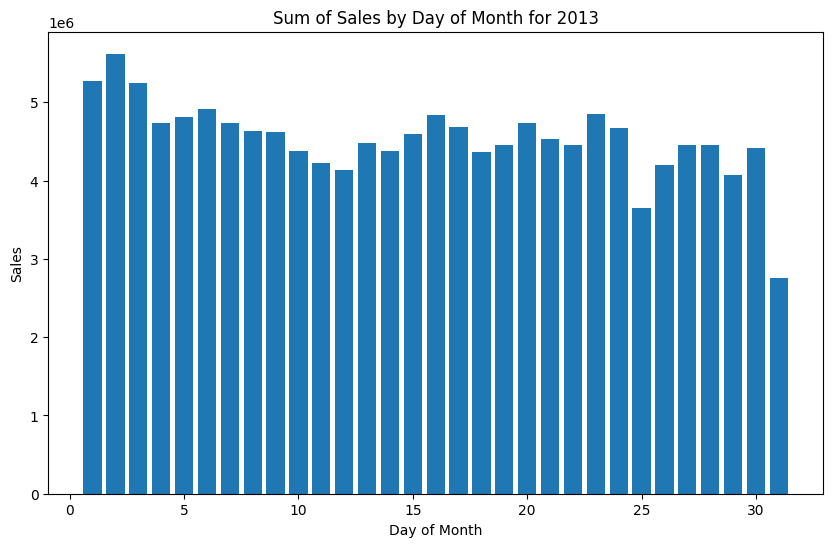

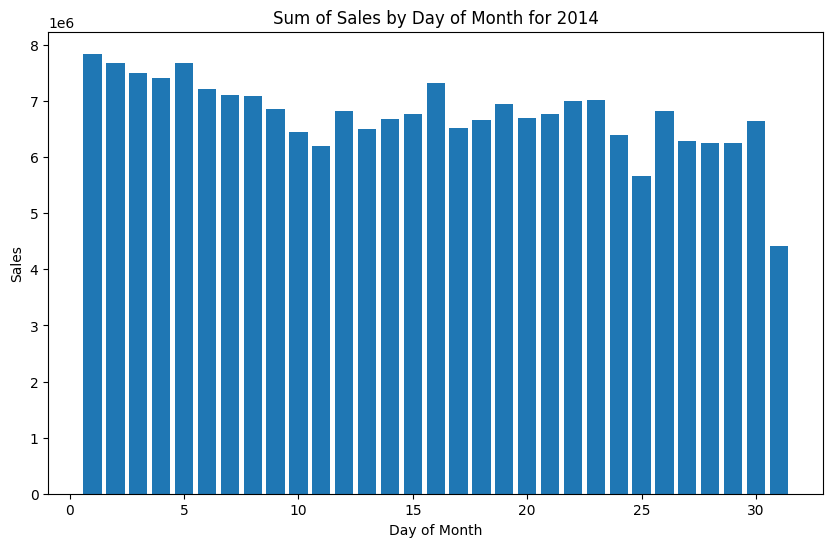

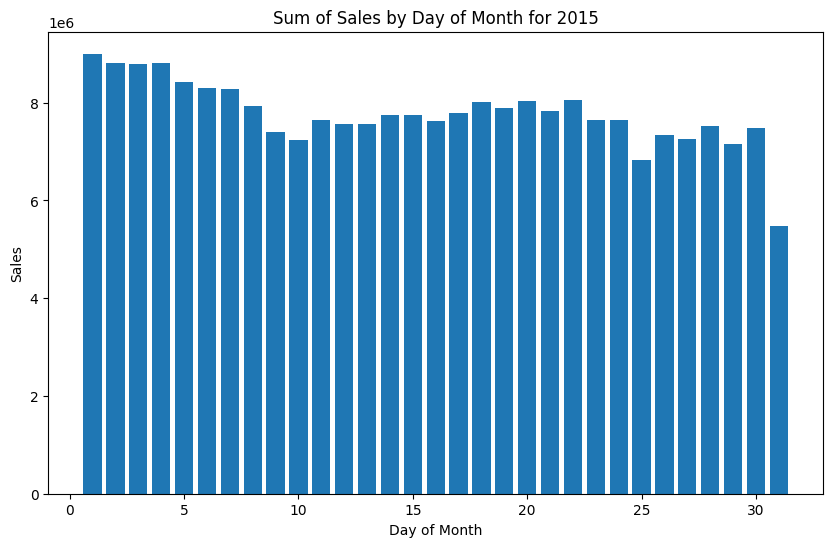

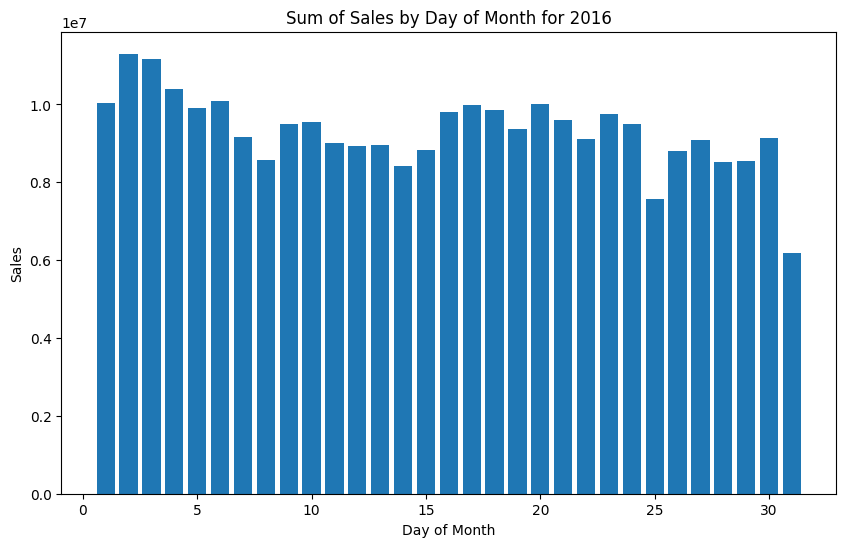

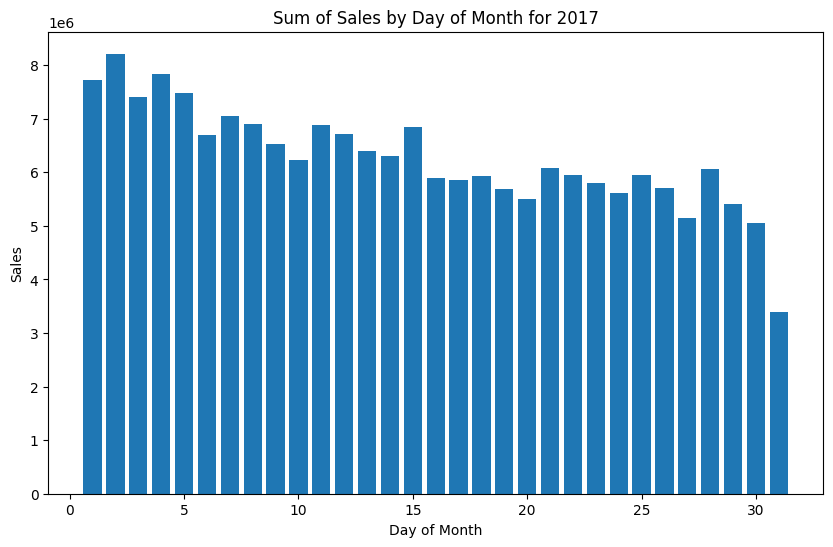

In [100]:
# Group sales data by year and day
grouped_by_year_and_day = train_df.groupby(['year', 'day']).agg(pl.sum('sales'))
 
# Convert the grouped data to Pandas DataFrame for plotting
grouped_by_year_and_day_df = grouped_by_year_and_day.to_pandas()
 
# Get unique years and sort them
unique_years = sorted(grouped_by_year_and_day_df['year'].unique())
 
 
# Plotting sales data for each year
for year in unique_years:
    # Filter data for the current year
    year_data = grouped_by_year_and_day_df[grouped_by_year_and_day_df['year'] == year]
   
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(year_data['day'], year_data['sales'])
    plt.xlabel("Day of Month")
    plt.ylabel("Sales")
    plt.title(f"Sum of Sales by Day of Month for {year}")
    plt.show()

#### `Hypothesis Testing`
`Null Hypothesis (Ho):` Holidays do not have a significant effect on the sales
 
`Alternate Hypothesis (Ha):` Holidays have a significant effect on the sales

We will use Mann-Whiteny to test to the Hypothesis because our sales has a high positive skweness and the distribution is not normal


In [69]:
train_holiday_oil_df.head(3)

shape: (3, 16)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ store_nbr ‚îÜ family     ‚îÜ sales ‚îÜ ‚Ä¶ ‚îÜ locale_nam ‚îÜ descripti ‚îÜ transferr ‚îÜ dcoilwtic ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---        ‚îÜ ---   ‚îÜ   ‚îÜ e          ‚îÜ on        ‚îÜ ed        ‚îÜ o         ‚îÇ
‚îÇ date       ‚îÜ i64       ‚îÜ str        ‚îÜ f64   ‚îÜ   ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ str        ‚îÜ str       ‚îÜ bool      ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ 1         ‚îÜ AUTOMOTIVE ‚îÜ 0.0   ‚îÜ ‚Ä¶ ‚îÜ Ecuador    ‚îÜ Primer    ‚îÜ false     ‚îÜ null      ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ dia del   ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ ano       ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2013-01-01 ‚îÜ 1         ‚îÜ BABY CARE  ‚îÜ 0.0   ‚îÜ ‚Ä¶ ‚îÜ Ecuador    ‚îÜ Primer    ‚îÜ false     ‚îÜ null      ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ dia del   ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ ano       ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2013-01-01 ‚îÜ 1         ‚îÜ BEAUTY     ‚îÜ 0.0   ‚îÜ ‚Ä¶ ‚îÜ Ecuador    ‚îÜ Primer    ‚îÜ false     ‚îÜ null      ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ dia del   ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ            ‚îÜ       ‚îÜ   ‚îÜ            ‚îÜ ano       ‚îÜ           ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [77]:
# Filter data for holidays (excluding transfers)
holiday_types = ['Holiday', 'Bridge', 'Additional', 'Event']
 
mask = pl.col('type').is_in(holiday_types)
 
with_holidays = train_holiday_oil_df.filter(mask)['sales']
 
without_holidays =  train_holiday_oil_df.filter(~mask)['sales']

In [82]:
# Perform Mann-Whitney U test to compare sales before and after the earthquake
u_stat, p_value = mannwhitneyu(with_holidays, without_holidays, alternative='two-sided')
 
# Significance level
alpha = 0.05
 
if p_value < alpha:
    print(f"Reject the Null Hypothesis, holidays do not have a significant effect on the sales ")
else:
    print(f"We fail to reject the Null Hypothesis, Holidays have a significant effect on the sales")

Reject the Null Hypothesis, holidays do not have a significant effect on the sales 


## `Data Preparation`

Statistical Models

Using Differencing to make the data stationary

In [78]:
# train_df['sales'] - train_df['sales'].shift(1)
train_df = train_df.with_columns((pl.col('sales')-pl.col('sales').shift(1)).alias('sales_diff'))

In [79]:
diff_df = train_df.group_by('date').agg(pl.col('sales_diff').sum())


In [80]:
# Resampling the data to weekly and getting the average
resampled_df = diff_df.group_by_dynamic("date", every="1w").agg(pl.col("sales_diff").mean())

resampled_df.shape

(242, 2)

In [81]:
# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(resampled_df['sales_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Perform differencing if needed for stationarity
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")


ADF Statistic: -11.118451839297938
p-value: 3.514685411916923e-20
Data is stationary


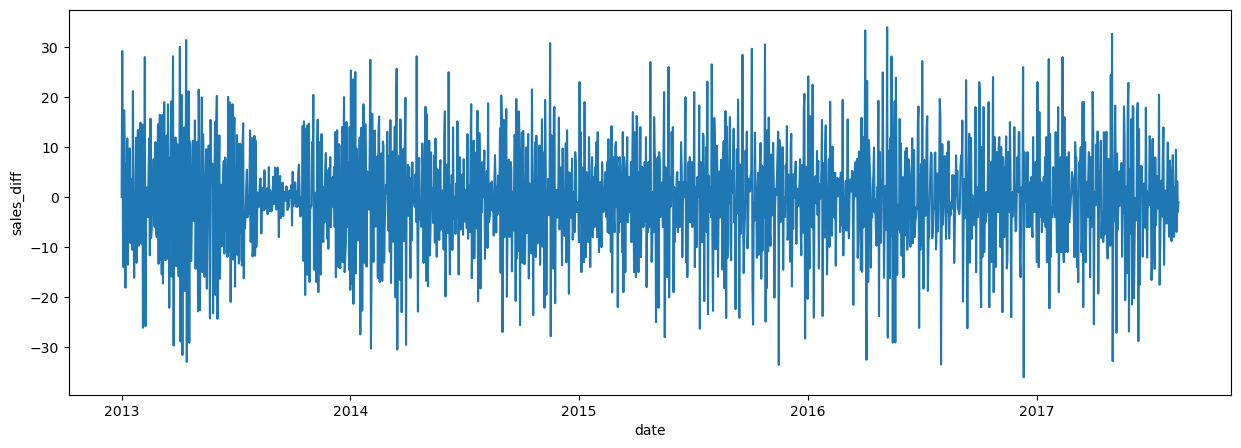

In [82]:
plt.figure(figsize = (15,5))
sns.lineplot(data = diff_df, x='date', y='sales_diff')
plt.show()

In [83]:
diff_df.head(2)

shape: (2, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ date       ‚îÜ sales_diff ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÇ
‚îÇ date       ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2013-01-01 ‚îÜ 0.0        ‚îÇ
‚îÇ 2013-01-02 ‚îÜ 29.214     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [119]:
from datetime import datetime

date_str = '01-01-2017'
date_format = '%m-%d-%Y'
date = datetime.strptime(date_str, date_format)

# Filter data for modeling
train = diff_df.filter(pl.col('date') < date)

test = diff_df.filter(pl.col('date') >= date)

Machine Learning Models

## `Modeling and Evaluation`

Modeling for Statistical Models
- SARIMA
- ARIMA
- Prophet

In [85]:
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, root_mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

In [167]:
# Define the SARIMA order and seasonal order
sarima_order = (1, 0, 1)
sarima_seasonal_order = (1, 0, 1, 7)

# Define the ARIMA order
arima_order = (1, 0, 1)

# Define the Prophet model
prophet_model = Prophet()

In [137]:
train.dtypes

date          datetime64[ms]
sales_diff           float64
dtype: object

train = train.to_pandas()
test = test.to_pandas()

In [140]:
np.array([1, 3]).reshape(-1, 1)

array([[1],
       [3]])

In [148]:
scaler = MinMaxScaler(feature_range=(0,1))

train_sales_diff_scaled = scaler.fit_transform(train[['sales_diff']])
train = train.with_columns(sales_diff_scaled=train_sales_diff_scaled)

test_sales_diff_scaled = scaler.transform(test[['sales_diff']])
test = test.with_columns(sales_diff_scaled=test_sales_diff_scaled)

In [151]:
train = train.to_pandas()
test = test.to_pandas()

In [153]:
train

date  sales_diff      sales_diff_scaled
0    2013-01-01        0.00   [0.5145871153104328]
1    2013-01-02       29.21   [0.9321745593848372]
2    2013-01-03       -4.21  [0.45435183464600326]
3    2013-01-04      -14.00   [0.3144699038008588]
4    2013-01-05       17.36   [0.7627467516688425]
...         ...         ...                    ...
1456 2016-12-27       -2.00    [0.485998942237588]
1457 2016-12-28       -3.00  [0.47170485570120946]
1458 2016-12-29        1.00   [0.5288812018468552]
1459 2016-12-30        7.00    [0.614645721065201]
1460 2016-12-31       -2.00    [0.485998942237705]

[1461 rows x 3 columns]

In [168]:
# Initialize lists to store evaluation metrics and forecast results
models = ['SARIMA', 'ARIMA', 'Prophet']
forecast_data = {'SARIMA': None, 'ARIMA': None, 'Prophet': None}
rmsle_results = []
mae_results = []
rmse_results = []

for model_name in models:
    print(f'Training {model_name}...')
    
    if model_name == 'SARIMA':
        model = SARIMAX(train['sales_diff'], order=sarima_order, seasonal_order=sarima_seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(len(test))
    elif model_name == 'ARIMA':
        model = ARIMA(train['sales_diff'], order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(len(test))
    else:  # Prophet
        prophet_train = train.reset_index().rename(columns={'date': 'ds', 'sales_diff': 'y'})
        prophet_test = test.reset_index().rename(columns={'date': 'ds', 'sales_diff': 'y'})
        model_fit = prophet_model.fit(prophet_train)
        forecast = model_fit.predict(prophet_test)['yhat'].values        
    
    forecast_data[model_name] = forecast
    # Calculate metrics
    # rmsle = root_mean_squared_log_error(test_sales_diff_scaled, forecast)  
    mae = mean_absolute_error(test['sales_diff'], forecast)
    rmse = mean_squared_error(test['sales_diff'], forecast, squared=False)
 
    # rmsle_results.append(rmsle)
    mae_results.append(mae)
    rmse_results.append(rmse)
# Display evaluation results
eval_results = pd.DataFrame({
    'Model': models,
    # 'RMSLE': rmsle_results,
    'MAE': mae_results,
    'RMSE': rmse_results
})
print('\nEvaluation Results:')
print(eval_results)



Training SARIMA...
Training ARIMA...


07:43:23 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet...


07:43:23 - cmdstanpy - INFO - Chain [1] done processing



Evaluation Results:
     Model  MAE  RMSE
0   SARIMA 8.01 10.74
1    ARIMA 8.60 11.08
2  Prophet 8.60 11.09


In [190]:
forecast_data['SARIMA'].reset_index().rename(columns={'predicted_mean': 'sales_diff'}).drop(columns='index')

sales_diff
0          6.44
1        -10.23
2         -2.01
3          0.06
4          0.42
..          ...
222       -1.01
223        9.39
224        3.37
225      -10.36
226       -2.03

[227 rows x 1 columns]

In [191]:
scaler.transform(forecast_data['SARIMA'].reset_index().rename(columns={'predicted_mean': 'sales_diff'}).drop(columns='index'))

array([[0.60661423],
       [0.36836794],
       [0.48582617],
       [0.51542491],
       [0.52060197],
       [0.49971726],
       [0.65337185],
       [0.56443437],
       [0.36135418],
       [0.48463469],
       [0.51521553],
       [0.52055986],
       [0.49972744],
       [0.65321927],
       [0.56437976],
       [0.36152148],
       [0.48466739],
       [0.51521484],
       [0.52055334],
       [0.49974366],
       [0.65306789],
       [0.56432539],
       [0.36168862],
       [0.48470006],
       [0.51521416],
       [0.52054683],
       [0.49975987],
       [0.65291667],
       [0.56427108],
       [0.36185558],
       [0.4847327 ],
       [0.51521347],
       [0.52054032],
       [0.49977606],
       [0.65276562],
       [0.56421682],
       [0.36202236],
       [0.4847653 ],
       [0.51521279],
       [0.52053382],
       [0.49979224],
       [0.65261474],
       [0.56416263],
       [0.36218896],
       [0.48479787],
       [0.5152121 ],
       [0.52052732],
       [0.499

In [201]:
forecast_data['Prophet']

array([-0.07951105, -0.07962933, -0.07974762, -0.07986591, -0.07998419,
       -0.08010248, -0.08022076, -0.08033905, -0.08045733, -0.08057527,
       -0.08069355, -0.08081184, -0.08093012, -0.08104841, -0.08116669,
       -0.08128498, -0.08140326, -0.08152155, -0.08163984, -0.08175812,
       -0.08187641, -0.08199434, -0.08211262, -0.08223091, -0.08234919,
       -0.08246748, -0.08258577, -0.08270405, -0.08282234, -0.08294062,
       -0.08305891, -0.08317719, -0.08329548, -0.08341341, -0.0835317 ,
       -0.08364998, -0.08376827, -0.08388655, -0.08400484, -0.08412312,
       -0.08424141, -0.0843597 , -0.08447798, -0.08459627, -0.0847142 ,
       -0.08483248, -0.08495077, -0.08506905, -0.08518734, -0.08530563,
       -0.08542391, -0.0855422 , -0.08566048, -0.08577877, -0.08589705,
       -0.08601534, -0.08613327, -0.08625156, -0.08636984, -0.08648813,
       -0.08660641, -0.0867247 , -0.08684298, -0.08696127, -0.08707956,
       -0.08719784, -0.08731613, -0.08743406, -0.08755234, -0.08

In [204]:
root_mean_squared_log_error(test_sales_diff_scaled, scaler.transform(forecast_data['ARIMA'].reset_index().rename(columns={'predicted_mean': 'sales_diff'}).drop(columns='index')))  


0.10636138520857157

**Key Insights**
1. We have identified missing dates in our date column, so we need to fill them in.
2. Our data is not on the same scale after reviewing the summary statistics. 
3. Our train dataset has a positive skewness
6. Noticed seasonal patterns in sales data, especially during holidays and events.
7. Identified outliers in sales, on promotion data that may need further investigation.
